<a href="https://colab.research.google.com/github/rebcervasio/Machine_Learning_Materials_Science_PhD/blob/main/Machine_Learning_Ferroelectric_Perovskites.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting if a perovskite material is polar or not (classification problem)
- The data is extracted from a Materials Project database (MongoDB): crystal structures, the name of the compound, its bandgap, its atomic composition, etc.
- The true labels are if a material is polar (True) or non-polar (False)




---------------------------------

### Used libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install scikit-plot==0.3.7

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install pymatgen  # open-source librarie for materials analysis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 114.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.2/71.2 KB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.1/515.1 KB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 KB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 KB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 KB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.9/135.9 KB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 555.3/555.3 KB 49.1 MB/s eta 0:00:

In [4]:
!pip install mp_api # api for connecting to materialsproject.org database

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [47]:
from pymatgen.ext.matproj  import MPRester                         # API connetion with Materials Project
from pymatgen.core.periodic_table import Element                   # chemical elements
from pymatgen.core.structure import Structure                      # crystal structures
from pymatgen.core.composition import Composition                  # compounds
from pymatgen.electronic_structure.plotter import BSPlotter        # band structure
from pymatgen.io import vasp                                       # VASP interface

import pandas as pd   
import numpy as np    
np.random.seed(1992) # Setting a random seed
import os             

import matplotlib.pyplot as plt 
import seaborn as sns        
sns.set_style("ticks")   

# Project 2 - Ferroelectric Perovskites

---------------------------
# Part 1 - Screening 

Screnning materials: automized search and collection of data for the analysis of ferroelectric perovskites

**Search Criteria:**
* Perovskite materials
* Reported band structure
* Thermodynamically stable

#### Database - Materials Project
Public materials database! 

Properties: https://workshop.materialsproject.org/lessons/04_materials_api/MAPI%20Lesson%20%28filled%29/.

Sintax (uses MongoDB) https://www.mongodb.com/docs/manual/reference/operator/query/

Available properties in: https://github.com/materialsproject/mapidoc/tree/master/materials


In [6]:
# Desired properties:
properties =['material_id', 'icsd_ids', 'pretty_formula','elements', 'band_gap','formation_energy_per_atom',
             'e_above_hull', 'spacegroup', 'structure']

# Acces password (got from the API in materialsproject.org/api)
apikey = 'Hjkg8maG5gcAhh31bWN'

In [7]:
# Connection with materialsproject.org database  (called API rest, to get data from their server)
with MPRester(apikey) as mpr:
    results = mpr.query("**O3", properties)

/usr/local/lib/python3.8/dist-packages/pymatgen/ext/matproj.py:186: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pymatgen/core/periodic_table.py:212: UserWarning: No electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pymatgen/core/periodic_table.py:212: UserWarning: No electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pymatgen/core/periodic_table.py:212: UserWarning: No electronegativity for 

variable <code>result</code> is type <code>list</code>, lets transform into <code>DataFrame</code>:

In [8]:
mat_list0 = pd.DataFrame(data = results) # transforming the results variable into dataframe
mat_list0

,material_id,icsd_ids,pretty_formula,elements,band_gap,formation_energy_per_atom,e_above_hull,spacegroup,structure
0,mp-1001571,[],CaFeO3,"[Ca, Fe, O]",0.0000,-2.282308,0.052161,"{'symprec': 0.1, 'source': 'spglib', 'symbol':...","[[1.918305 1.918305 1.918305] Ca, [0. 0. 0.] F..."
1,mp-1016821,[],BaSiO3,"[Ba, Si, O]",1.0186,-2.852291,0.561269,"{'symprec': 0.1, 'source': 'spglib', 'symbol':...","[[0. 0. 0.] Ba, [1.9184685 1.9184685 1.9184685..."
2,mp-1016823,[],BaGeO3,"[Ba, Ge, O]",0.0000,-2.473919,0.232358,"{'symprec': 0.1, 'source': 'spglib', 'symbol':...","[[0. 0. 0.] Ba, [1.9901945 1.9901945 1.9901945..."
3,mp-1016828,[],CdIrO3,"[Cd, Ir, O]",0.0000,-0.851737,0.463199,"{'symprec': 0.1, 'source': 'spglib', 'symbol':...","[[0. 0. 0.] Cd, [1.9765825 1.9765825 1.9765825..."
4,mp-1016833,[],CaRhO3,"[Ca, Rh, O]",0.0000,-1.851243,0.257081,"{'symprec': 0.1, 'source': 'spglib', 'symbol':...","[[0. 0. 0.] Ca, [1.9771045 1.9771045 1.9771045..."
...,...,...,...,...,...,...,...,...,...
2393,mvc-4001,[],ZnCrO3,"[Cr, O, Zn]",0.0280,-1.851246,0.139167,"{'symprec': 0.1, 'source': 'spglib', 'symbol':...","[[0.0729279 0.15563595 1.91181034] Zn, [2.624..."
2394,mvc-4002,[],ZnMoO3,"[Mo, O, Zn]",0.8663,-1.780286,0.221352,"{'symprec': 0.1, 'source': 'spglib', 'symbol':...","[[2.74470566 0.11676461 1.9926375 ] Zn, [0.087..."
2395,mvc-4008,[],ZnNiO3,"[Ni, O, Zn]",0.0000,-0.965703,0.186033,"{'symprec': 0.1, 'source': 'spglib', 'symbol':...","[[2.48261735 0.28181008 5.52606225] Zn, [5.009..."
2396,mvc-4013,[],ZnWO3,"[O, W, Zn]",1.7419,-1.768571,0.123491,"{'symprec': 0.1, 'source': 'spglib', 'symbol':...","[[2.7635265 0.10291022 1.985186 ] Zn, [0.098..."


In [9]:
type(results),  type(mat_list0) # analysing types

(list, pandas.core.frame.DataFrame)

In [10]:
len(mat_list0) # analysing dataframe, 2398 materials found

2398

In [11]:
mat_list0.head(10) # checking how it looks like

,material_id,icsd_ids,pretty_formula,elements,band_gap,formation_energy_per_atom,e_above_hull,spacegroup,structure
0,mp-1001571,[],CaFeO3,"[Ca, Fe, O]",0.0000,-2.282308,0.052161,"{'symprec': 0.1, 'source': 'spglib', 'symbol':...","[[1.918305 1.918305 1.918305] Ca, [0. 0. 0.] F..."
1,mp-1016821,[],BaSiO3,"[Ba, Si, O]",1.0186,-2.852291,0.561269,"{'symprec': 0.1, 'source': 'spglib', 'symbol':...","[[0. 0. 0.] Ba, [1.9184685 1.9184685 1.9184685..."
2,mp-1016823,[],BaGeO3,"[Ba, Ge, O]",0.0000,-2.473919,0.232358,"{'symprec': 0.1, 'source': 'spglib', 'symbol':...","[[0. 0. 0.] Ba, [1.9901945 1.9901945 1.9901945..."
3,mp-1016828,[],CdIrO3,"[Cd, Ir, O]",0.0000,-0.851737,0.463199,"{'symprec': 0.1, 'source': 'spglib', 'symbol':...","[[0. 0. 0.] Cd, [1.9765825 1.9765825 1.9765825..."
4,mp-1016833,[],CaRhO3,"[Ca, Rh, O]",0.0000,-1.851243,0.257081,"{'symprec': 0.1, 'source': 'spglib', 'symbol':...","[[0. 0. 0.] Ca, [1.9771045 1.9771045 1.9771045..."
5,mp-1016835,[],CaRuO3,"[Ca, O, Ru]",0.0000,-2.071863,0.151843,"{'symprec': 0.1, 'source': 'spglib', 'symbol':...","[[0. 0. 0.] Ca, [1.964772 1.964772 1.964772] R..."
6,mp-1016849,[],CdRuO3,"[Cd, Ru, O]",0.0000,-1.082652,0.350347,"{'symprec': 0.1, 'source': 'spglib', 'symbol':...","[[0. 0. 0.] Cd, [1.9641115 1.9641115 1.9641115..."
7,mp-1016850,[],BaRhO3,"[Ba, Rh, O]",0.0000,-1.928768,0.098332,"{'symprec': 0.1, 'source': 'spglib', 'symbol':...","[[0. 0. 0.] Ba, [2.0472275 2.0472275 2.0472275..."
8,mp-1016852,[],BaMnO3,"[Ba, Mn, O]",0.0000,-2.368006,0.126123,"{'symprec': 0.1, 'source': 'spglib', 'symbol':...","[[2.0166565 2.0166565 2.0166565] Ba, [0. 0. 0...."
9,mp-1016853,[],CaVO3,"[Ca, V, O]",0.0000,-2.838377,0.105976,"{'symprec': 0.1, 'source': 'spglib', 'symbol':...","[[0. 0. 0.] Ca, [1.915203 1.915203 1.915203] V..."


Column <code>spacegroup</code> is of type <code>dict</code>. Lets transform it in multiple columns:

In [12]:
# Each key of space group dict columns will become an individual column
mat_list0[['symprec',
          'source',
          'symbol',
          'number',
          'point_group',
          'crystal_system',
          'hall']] = mat_list0.spacegroup.apply(pd.Series)
mat_list0 = mat_list0.drop('spacegroup', axis=1)

In [13]:
mat_list0.head()

,material_id,icsd_ids,pretty_formula,elements,band_gap,formation_energy_per_atom,e_above_hull,structure,symprec,source,symbol,number,point_group,crystal_system,hall
0,mp-1001571,[],CaFeO3,"[Ca, Fe, O]",0.0000,-2.282308,0.052161,"[[1.918305 1.918305 1.918305] Ca, [0. 0. 0.] F...",0.1,spglib,Pm-3m,221,m-3m,cubic,-P 4 2 3
1,mp-1016821,[],BaSiO3,"[Ba, Si, O]",1.0186,-2.852291,0.561269,"[[0. 0. 0.] Ba, [1.9184685 1.9184685 1.9184685...",0.1,spglib,Pm-3m,221,m-3m,cubic,-P 4 2 3
2,mp-1016823,[],BaGeO3,"[Ba, Ge, O]",0.0000,-2.473919,0.232358,"[[0. 0. 0.] Ba, [1.9901945 1.9901945 1.9901945...",0.1,spglib,Pm-3m,221,m-3m,cubic,-P 4 2 3
3,mp-1016828,[],CdIrO3,"[Cd, Ir, O]",0.0000,-0.851737,0.463199,"[[0. 0. 0.] Cd, [1.9765825 1.9765825 1.9765825...",0.1,spglib,Pm-3m,221,m-3m,cubic,-P 4 2 3
4,mp-1016833,[],CaRhO3,"[Ca, Rh, O]",0.0000,-1.851243,0.257081,"[[0. 0. 0.] Ca, [1.9771045 1.9771045 1.9771045...",0.1,spglib,Pm-3m,221,m-3m,cubic,-P 4 2 3


In [14]:
# the content inside the structure column is a mix of strings and dicts
# lets reorganize the info we want into a new df, to then append to mat_list0

appended_data = [] # to store each row as a df inside a list

for index, row in mat_list0.iterrows():
  mat_list0["structure"].iloc[index] = row["structure"].as_dict() # transforms content into dict using the attribute .as_dict()
  mat_list0["structure"].iloc[index] = mat_list0["structure"].iloc[index][3] # takes the third dict that we want

  test = mat_list0["structure"][index].apply(lambda x: pd.Series(str(x).split(" "))) # splits into column and values
  test = test.T.drop(["matrix", "pbc"], axis=1) # drops the ones we dont want
  test = test.iloc[0]  # selects only the first row (the rest is NAN)
  test = pd.DataFrame(test).T # transforms into df

  appended_data.append(test) # appends to the list of dfs

appended_data = pd.concat(appended_data) # concats all dfs

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [15]:
appended_data.head() # the new structure column to be appended to the main df (mat_list0)

,a,b,c,alpha,beta,gamma,volume
0,3.83661,3.83661,3.83661,90.0,90.0,90.0,56.47327359803378
0,3.836937,3.836937,3.836937,90.0,90.0,90.0,56.48771473314591
0,3.980389,3.980389,3.980389,90.0,90.0,90.0,63.06327955363161
0,3.953165,3.953165,3.953165,90.0,90.0,90.0,61.77813947332076
0,3.954209,3.954209,3.954209,90.0,90.0,90.0,61.82709777288515


In [16]:
appended_data = appended_data.reset_index(drop=True) # needs to reset_index to be able to concat with mat_list0
appended_data

,a,b,c,alpha,beta,gamma,volume
0,3.83661,3.83661,3.83661,90.0,90.0,90.0,56.47327359803378
1,3.836937,3.836937,3.836937,90.0,90.0,90.0,56.48771473314591
2,3.980389,3.980389,3.980389,90.0,90.0,90.0,63.06327955363161
3,3.953165,3.953165,3.953165,90.0,90.0,90.0,61.77813947332076
4,3.954209,3.954209,3.954209,90.0,90.0,90.0,61.82709777288515
...,...,...,...,...,...,...,...
2393,5.105534017852491,5.127049013048636,7.646973042584497,90.00792296327013,90.00937750492726,89.9986894363993,200.16963281443952
2394,5.313914,5.338543,7.97055,90.0,90.0,90.0,226.11301305390992
2395,5.053746,5.156729,7.368083,90.0,90.0,90.0,192.01812681303318
2396,5.330486,5.384023,7.940744,90.0,90.0,90.0,227.89505864557682


In [17]:
mat_list0.head() 

,material_id,icsd_ids,pretty_formula,elements,band_gap,formation_energy_per_atom,e_above_hull,structure,symprec,source,symbol,number,point_group,crystal_system,hall
0,mp-1001571,[],CaFeO3,"[Ca, Fe, O]",0.0000,-2.282308,0.052161,"matrix [[3.83661, 0.0, 0.0], [0.0, 3.83661,...",0.1,spglib,Pm-3m,221,m-3m,cubic,-P 4 2 3
1,mp-1016821,[],BaSiO3,"[Ba, Si, O]",1.0186,-2.852291,0.561269,"matrix [[3.836937, 0.0, 0.0], [0.0, 3.83693...",0.1,spglib,Pm-3m,221,m-3m,cubic,-P 4 2 3
2,mp-1016823,[],BaGeO3,"[Ba, Ge, O]",0.0000,-2.473919,0.232358,"matrix [[3.980389, 0.0, 0.0], [0.0, 3.98038...",0.1,spglib,Pm-3m,221,m-3m,cubic,-P 4 2 3
3,mp-1016828,[],CdIrO3,"[Cd, Ir, O]",0.0000,-0.851737,0.463199,"matrix [[3.953165, 0.0, 0.0], [0.0, 3.95316...",0.1,spglib,Pm-3m,221,m-3m,cubic,-P 4 2 3
4,mp-1016833,[],CaRhO3,"[Ca, Rh, O]",0.0000,-1.851243,0.257081,"matrix [[3.954209, 0.0, 0.0], [0.0, 3.95420...",0.1,spglib,Pm-3m,221,m-3m,cubic,-P 4 2 3


In [18]:
mat_list0 = mat_list0.reset_index(drop=True) # both are ready to concat
mat_list0

,material_id,icsd_ids,pretty_formula,elements,band_gap,formation_energy_per_atom,e_above_hull,structure,symprec,source,symbol,number,point_group,crystal_system,hall
0,mp-1001571,[],CaFeO3,"[Ca, Fe, O]",0.0000,-2.282308,0.052161,"matrix [[3.83661, 0.0, 0.0], [0.0, 3.83661,...",0.1,spglib,Pm-3m,221,m-3m,cubic,-P 4 2 3
1,mp-1016821,[],BaSiO3,"[Ba, Si, O]",1.0186,-2.852291,0.561269,"matrix [[3.836937, 0.0, 0.0], [0.0, 3.83693...",0.1,spglib,Pm-3m,221,m-3m,cubic,-P 4 2 3
2,mp-1016823,[],BaGeO3,"[Ba, Ge, O]",0.0000,-2.473919,0.232358,"matrix [[3.980389, 0.0, 0.0], [0.0, 3.98038...",0.1,spglib,Pm-3m,221,m-3m,cubic,-P 4 2 3
3,mp-1016828,[],CdIrO3,"[Cd, Ir, O]",0.0000,-0.851737,0.463199,"matrix [[3.953165, 0.0, 0.0], [0.0, 3.95316...",0.1,spglib,Pm-3m,221,m-3m,cubic,-P 4 2 3
4,mp-1016833,[],CaRhO3,"[Ca, Rh, O]",0.0000,-1.851243,0.257081,"matrix [[3.954209, 0.0, 0.0], [0.0, 3.95420...",0.1,spglib,Pm-3m,221,m-3m,cubic,-P 4 2 3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2393,mvc-4001,[],ZnCrO3,"[Cr, O, Zn]",0.0280,-1.851246,0.139167,"matrix [[5.105534, 5.8e-05, -0.000423], [5....",0.1,spglib,Pnma,62,mmm,orthorhombic,-P 2ac 2n
2394,mvc-4002,[],ZnMoO3,"[Mo, O, Zn]",0.8663,-1.780286,0.221352,"matrix [[5.313914, 0.0, 0.0], [0.0, 5.33854...",0.1,spglib,Pnma,62,mmm,orthorhombic,-P 2ac 2n
2395,mvc-4008,[],ZnNiO3,"[Ni, O, Zn]",0.0000,-0.965703,0.186033,"matrix [[5.053746, 0.0, 0.0], [0.0, 5.15672...",0.1,spglib,Pnma,62,mmm,orthorhombic,-P 2ac 2n
2396,mvc-4013,[],ZnWO3,"[O, W, Zn]",1.7419,-1.768571,0.123491,"matrix [[5.330486, 0.0, 0.0], [0.0, 5.38402...",0.1,spglib,Pnma,62,mmm,orthorhombic,-P 2ac 2n


In [19]:
mat_list0 = pd.concat([mat_list0, appended_data], axis=1)
mat_list0

,material_id,icsd_ids,pretty_formula,elements,band_gap,formation_energy_per_atom,e_above_hull,structure,symprec,source,...,point_group,crystal_system,hall,a,b,c,alpha,beta,gamma,volume
0,mp-1001571,[],CaFeO3,"[Ca, Fe, O]",0.0000,-2.282308,0.052161,"matrix [[3.83661, 0.0, 0.0], [0.0, 3.83661,...",0.1,spglib,...,m-3m,cubic,-P 4 2 3,3.83661,3.83661,3.83661,90.0,90.0,90.0,56.47327359803378
1,mp-1016821,[],BaSiO3,"[Ba, Si, O]",1.0186,-2.852291,0.561269,"matrix [[3.836937, 0.0, 0.0], [0.0, 3.83693...",0.1,spglib,...,m-3m,cubic,-P 4 2 3,3.836937,3.836937,3.836937,90.0,90.0,90.0,56.48771473314591
2,mp-1016823,[],BaGeO3,"[Ba, Ge, O]",0.0000,-2.473919,0.232358,"matrix [[3.980389, 0.0, 0.0], [0.0, 3.98038...",0.1,spglib,...,m-3m,cubic,-P 4 2 3,3.980389,3.980389,3.980389,90.0,90.0,90.0,63.06327955363161
3,mp-1016828,[],CdIrO3,"[Cd, Ir, O]",0.0000,-0.851737,0.463199,"matrix [[3.953165, 0.0, 0.0], [0.0, 3.95316...",0.1,spglib,...,m-3m,cubic,-P 4 2 3,3.953165,3.953165,3.953165,90.0,90.0,90.0,61.77813947332076
4,mp-1016833,[],CaRhO3,"[Ca, Rh, O]",0.0000,-1.851243,0.257081,"matrix [[3.954209, 0.0, 0.0], [0.0, 3.95420...",0.1,spglib,...,m-3m,cubic,-P 4 2 3,3.954209,3.954209,3.954209,90.0,90.0,90.0,61.82709777288515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2393,mvc-4001,[],ZnCrO3,"[Cr, O, Zn]",0.0280,-1.851246,0.139167,"matrix [[5.105534, 5.8e-05, -0.000423], [5....",0.1,spglib,...,mmm,orthorhombic,-P 2ac 2n,5.105534017852491,5.127049013048636,7.646973042584497,90.00792296327013,90.00937750492726,89.9986894363993,200.16963281443952
2394,mvc-4002,[],ZnMoO3,"[Mo, O, Zn]",0.8663,-1.780286,0.221352,"matrix [[5.313914, 0.0, 0.0], [0.0, 5.33854...",0.1,spglib,...,mmm,orthorhombic,-P 2ac 2n,5.313914,5.338543,7.97055,90.0,90.0,90.0,226.11301305390992
2395,mvc-4008,[],ZnNiO3,"[Ni, O, Zn]",0.0000,-0.965703,0.186033,"matrix [[5.053746, 0.0, 0.0], [0.0, 5.15672...",0.1,spglib,...,mmm,orthorhombic,-P 2ac 2n,5.053746,5.156729,7.368083,90.0,90.0,90.0,192.01812681303318
2396,mvc-4013,[],ZnWO3,"[O, W, Zn]",1.7419,-1.768571,0.123491,"matrix [[5.330486, 0.0, 0.0], [0.0, 5.38402...",0.1,spglib,...,mmm,orthorhombic,-P 2ac 2n,5.330486,5.384023,7.940744,90.0,90.0,90.0,227.89505864557682


In [20]:
mat_list0 = mat_list0.drop(['structure', "icsd_ids"], axis=1) # drop old structure column, icsd_ids is just empty lists
mat_list0.head()

,material_id,pretty_formula,elements,band_gap,formation_energy_per_atom,e_above_hull,symprec,source,symbol,number,point_group,crystal_system,hall,a,b,c,alpha,beta,gamma,volume
0,mp-1001571,CaFeO3,"[Ca, Fe, O]",0.0000,-2.282308,0.052161,0.1,spglib,Pm-3m,221,m-3m,cubic,-P 4 2 3,3.83661,3.83661,3.83661,90.0,90.0,90.0,56.47327359803378
1,mp-1016821,BaSiO3,"[Ba, Si, O]",1.0186,-2.852291,0.561269,0.1,spglib,Pm-3m,221,m-3m,cubic,-P 4 2 3,3.836937,3.836937,3.836937,90.0,90.0,90.0,56.48771473314591
2,mp-1016823,BaGeO3,"[Ba, Ge, O]",0.0000,-2.473919,0.232358,0.1,spglib,Pm-3m,221,m-3m,cubic,-P 4 2 3,3.980389,3.980389,3.980389,90.0,90.0,90.0,63.06327955363161
3,mp-1016828,CdIrO3,"[Cd, Ir, O]",0.0000,-0.851737,0.463199,0.1,spglib,Pm-3m,221,m-3m,cubic,-P 4 2 3,3.953165,3.953165,3.953165,90.0,90.0,90.0,61.77813947332076
4,mp-1016833,CaRhO3,"[Ca, Rh, O]",0.0000,-1.851243,0.257081,0.1,spglib,Pm-3m,221,m-3m,cubic,-P 4 2 3,3.954209,3.954209,3.954209,90.0,90.0,90.0,61.82709777288515


Last step: lets split the "elements" column into 3 columns

In [21]:
mat_list0 = pd.concat([mat_list0, mat_list0["elements"].apply(pd.Series)], axis=1)
mat_list0 = mat_list0.rename(columns={0: "element_A", 1:"element_B", 2:"element_C"})
mat_list0 = mat_list0.drop(["elements"], axis=1)
mat_list0.head()

,material_id,pretty_formula,band_gap,formation_energy_per_atom,e_above_hull,symprec,source,symbol,number,point_group,...,a,b,c,alpha,beta,gamma,volume,element_A,element_B,element_C
0,mp-1001571,CaFeO3,0.0000,-2.282308,0.052161,0.1,spglib,Pm-3m,221,m-3m,...,3.83661,3.83661,3.83661,90.0,90.0,90.0,56.47327359803378,Ca,Fe,O
1,mp-1016821,BaSiO3,1.0186,-2.852291,0.561269,0.1,spglib,Pm-3m,221,m-3m,...,3.836937,3.836937,3.836937,90.0,90.0,90.0,56.48771473314591,Ba,Si,O
2,mp-1016823,BaGeO3,0.0000,-2.473919,0.232358,0.1,spglib,Pm-3m,221,m-3m,...,3.980389,3.980389,3.980389,90.0,90.0,90.0,63.06327955363161,Ba,Ge,O
3,mp-1016828,CdIrO3,0.0000,-0.851737,0.463199,0.1,spglib,Pm-3m,221,m-3m,...,3.953165,3.953165,3.953165,90.0,90.0,90.0,61.77813947332076,Cd,Ir,O
4,mp-1016833,CaRhO3,0.0000,-1.851243,0.257081,0.1,spglib,Pm-3m,221,m-3m,...,3.954209,3.954209,3.954209,90.0,90.0,90.0,61.82709777288515,Ca,Rh,O


# Part 2 - Exploring and Preprocessing data

#### **Quantitative Variables**

In [22]:
mat_list0.describe() # Statistics on numerical columns 

# positive formation energy - not stable

,band_gap,formation_energy_per_atom,e_above_hull,symprec,number
count,2398.000000,2398.000000,2398.000000,2.398000e+03,2398.000000
mean,1.230595,-2.265419,0.242377,1.000000e-01,129.995413
std,1.598627,0.869457,0.372420,1.388068e-17,85.860140
min,0.000000,-4.037959,0.000000,1.000000e-01,1.000000
25%,0.000000,-2.885303,0.018840,1.000000e-01,62.000000
50%,0.097650,-2.336232,0.084684,1.000000e-01,148.000000
75%,2.403725,-1.645397,0.330591,1.000000e-01,221.000000
max,5.906300,1.978078,4.155444,1.000000e-01,227.000000


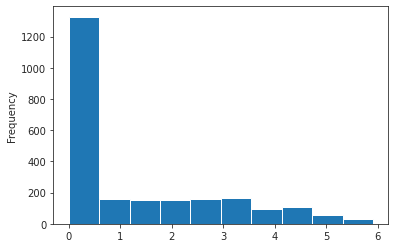

In [23]:
mat_list0.band_gap.plot(kind='hist')  # Bandgap histogram
# most of bandgaps are between 0 and 0.5 eV

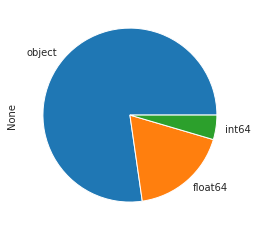

In [24]:
mat_list0.dtypes.value_counts().plot.pie()

band_gap
formation_energy_per_atom
e_above_hull
symprec


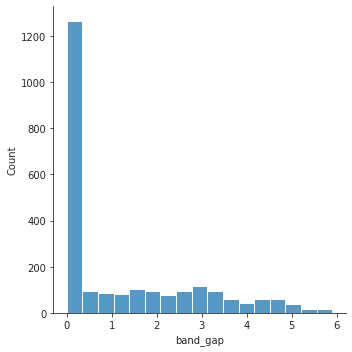

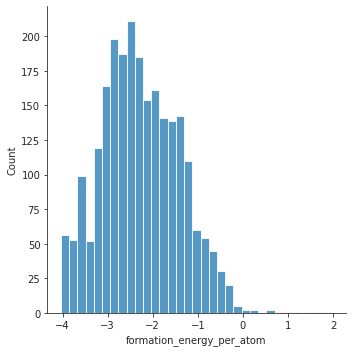

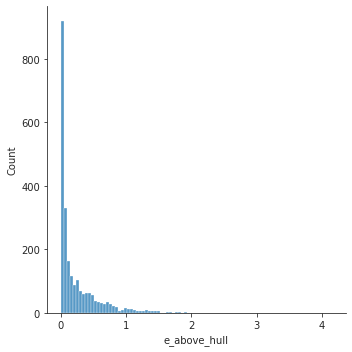

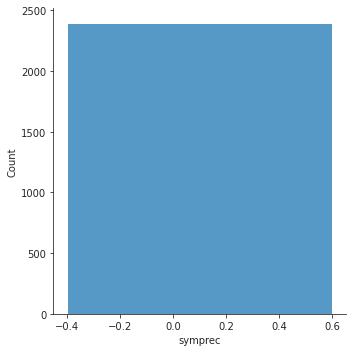

In [25]:
for col in mat_list0.select_dtypes('float'):
    print(col)
    sns.displot(mat_list0[col]) # histogram for continuous varibales

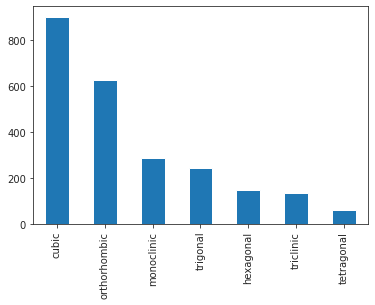

In [26]:
mat_list0.crystal_system.value_counts().plot(kind='bar')  # Distribution of crystal phases

In [27]:
mat_list0.isna().sum()

material_id                  0
pretty_formula               0
band_gap                     0
formation_energy_per_atom    0
e_above_hull                 0
symprec                      0
source                       0
symbol                       0
number                       0
point_group                  0
crystal_system               0
hall                         0
a                            0
b                            0
c                            0
alpha                        0
beta                         0
gamma                        0
volume                       0
element_A                    0
element_B                    0
element_C                    0
dtype: int64

In [28]:
mat_list0.groupby('crystal_system')['band_gap'].describe() # Gives the bandgap (describe()) statistics for each crystal phase

,count,mean,std,min,25%,50%,75%,max
crystal_system,,,,,,,,
cubic,900.0,0.299393,0.848549,0.0,0.000000,0.00000,0.000000,5.7371
hexagonal,146.0,1.106845,1.326495,0.0,0.000000,0.46975,2.077600,5.1115
monoclinic,287.0,2.117925,1.747984,0.0,0.322350,1.99650,3.431050,5.6554
orthorhombic,626.0,1.766396,1.690131,0.0,0.000000,1.49845,3.070125,5.8359
tetragonal,61.0,1.763107,1.594193,0.0,0.000000,1.66030,3.459900,4.7722
triclinic,134.0,1.778943,1.654497,0.0,0.233575,1.35840,3.068000,5.5411
trigonal,244.0,1.886797,1.693106,0.0,0.000000,1.93530,3.067825,5.9063


#### **Qualitative Variables**

In [29]:
mat_list0.columns

Index(['material_id', 'pretty_formula', 'band_gap',
       'formation_energy_per_atom', 'e_above_hull', 'symprec', 'source',
       'symbol', 'number', 'point_group', 'crystal_system', 'hall', 'a', 'b',
       'c', 'alpha', 'beta', 'gamma', 'volume', 'element_A', 'element_B',
       'element_C'],
      dtype='object')

In [30]:
#toute les variables du type object
# we can see that many of the quantitative variables are strings, we need to convert to float

for col in mat_list0.select_dtypes('object'):
    print(f'{col :-<40} {mat_list0[col].unique()}')

material_id----------------------------- ['mp-1001571' 'mp-1016821' 'mp-1016823' ... 'mvc-4008' 'mvc-4013'
 'mvc-5731']
pretty_formula-------------------------- ['CaFeO3' 'BaSiO3' 'BaGeO3' ... 'ZnMoO3' 'ZnNiO3' 'ZnWO3']
source---------------------------------- ['spglib']
symbol---------------------------------- ['Pm-3m' 'I4/mcm' 'Pnma' 'Amm2' 'P2_1/m' 'Cmcm' 'P-1' 'P4/nmm' 'Imma'
 'P6_3/mmc' 'R-3' 'R3m' 'Pbam' 'Im-3' 'P1' 'P2_1/c' 'C2/c' 'Pbca' 'P6_3mc'
 'R32' 'P6_3cm' 'P2_1' 'Pmma' 'R-3m' 'C2/m' 'P2_12_12_1' 'P-3m1' 'P4/mmm'
 'Pna2_1' 'Fm-3m' 'Pca2_1' 'I4/m' 'Pmmn' 'P4/mbm' 'R-3c' 'Fd-3m' 'I4/mmm'
 'C222_1' 'R3c' 'I4_1/a' 'P6_522' 'P4_3' 'C2' 'P4mm' 'Pnn2' 'Ibca'
 'Cmc2_1' 'R3' 'Cmmm' 'P-6m2' 'Cm' 'P2_13' 'Pbcn' 'Pba2' 'Pmc2_1'
 'P2_12_12' 'P-31m' 'Cc' 'Pa-3' 'P4_132' 'Ama2' 'Pmn2_1' 'Pn-3' 'Pbcm'
 'P2/c' 'Pcca' 'P321' 'Cmce' 'P3_1' 'P-6' 'Pc' 'P-3c1' 'P222_1' 'Pnnm'
 'P4/m' 'P6_3' 'P4_2/n' 'Pccn' 'Pnna' 'P6_322' 'P4_2/mbc' 'Pmmm'
 'I4_1/amd' 'P-62m' 'P3_2' 'Fdd2' 'I-4m2' 'Ibam' 'I2_1

In [31]:
mat_list0.select_dtypes('object').head()

,material_id,pretty_formula,source,symbol,point_group,crystal_system,hall,a,b,c,alpha,beta,gamma,volume,element_A,element_B,element_C
0,mp-1001571,CaFeO3,spglib,Pm-3m,m-3m,cubic,-P 4 2 3,3.83661,3.83661,3.83661,90.0,90.0,90.0,56.47327359803378,Ca,Fe,O
1,mp-1016821,BaSiO3,spglib,Pm-3m,m-3m,cubic,-P 4 2 3,3.836937,3.836937,3.836937,90.0,90.0,90.0,56.48771473314591,Ba,Si,O
2,mp-1016823,BaGeO3,spglib,Pm-3m,m-3m,cubic,-P 4 2 3,3.980389,3.980389,3.980389,90.0,90.0,90.0,63.06327955363161,Ba,Ge,O
3,mp-1016828,CdIrO3,spglib,Pm-3m,m-3m,cubic,-P 4 2 3,3.953165,3.953165,3.953165,90.0,90.0,90.0,61.77813947332076,Cd,Ir,O
4,mp-1016833,CaRhO3,spglib,Pm-3m,m-3m,cubic,-P 4 2 3,3.954209,3.954209,3.954209,90.0,90.0,90.0,61.82709777288515,Ca,Rh,O


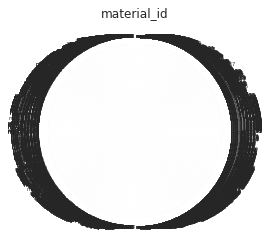

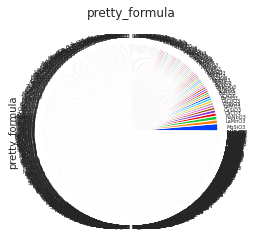

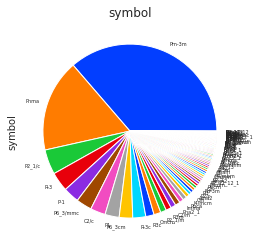

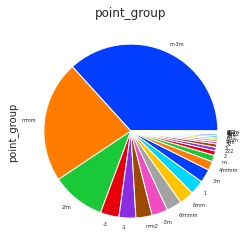

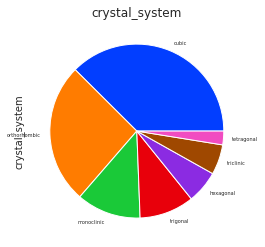

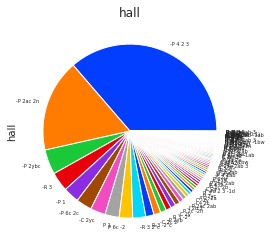

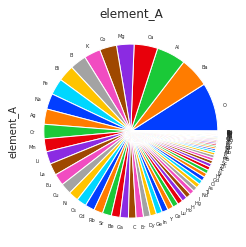

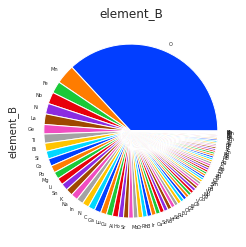

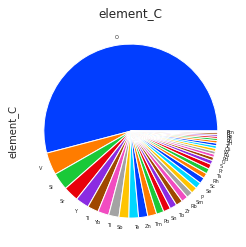

In [46]:
palette_color = sns.color_palette('bright')
for col in mat_list0.select_dtypes('object'):
    plt.figure()
    mat_list0[col].value_counts().plot.pie(fontsize=5, title=col, colors=palette_color)

**conclusion of qualitative and quantitative analysis**: some of the features have only one value (variance is zero or close to zero)
- we can use the **variance threshold** to select them

In [48]:
mat_list0.var(axis=0)

<ipython-input-48-25e0a6c3be8a>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mat_list0.var(axis=0)


band_gap                         2.555607
formation_energy_per_atom        0.755956
e_above_hull                     0.138697
number                        7371.963684
a                                2.903392
b                                3.129308
c                               16.516251
alpha                          156.575175
beta                           135.961313
gamma                          247.560465
volume                       75992.190753
dtype: float64

In [49]:
mat_list0.apply(pd.Series.nunique) != 1 # we see that tehre are 3 columns in which there is only one value

material_id                  True
pretty_formula               True
band_gap                     True
formation_energy_per_atom    True
e_above_hull                 True
symbol                       True
number                       True
point_group                  True
crystal_system               True
hall                         True
a                            True
b                            True
c                            True
alpha                        True
beta                         True
gamma                        True
volume                       True
element_A                    True
element_B                    True
element_C                    True
dtype: bool

In [50]:
mat_list0 = mat_list0.loc[:,mat_list0.apply(pd.Series.nunique) != 1] # removing the columns that have only one value (no variance!)
mat_list0.head()

,material_id,pretty_formula,band_gap,formation_energy_per_atom,e_above_hull,symbol,number,point_group,crystal_system,hall,a,b,c,alpha,beta,gamma,volume,element_A,element_B,element_C
0,mp-1001571,CaFeO3,0.0000,-2.282308,0.052161,Pm-3m,221,m-3m,cubic,-P 4 2 3,3.836610,3.836610,3.836610,90.0,90.0,90.0,56.473274,Ca,Fe,O
1,mp-1016821,BaSiO3,1.0186,-2.852291,0.561269,Pm-3m,221,m-3m,cubic,-P 4 2 3,3.836937,3.836937,3.836937,90.0,90.0,90.0,56.487715,Ba,Si,O
2,mp-1016823,BaGeO3,0.0000,-2.473919,0.232358,Pm-3m,221,m-3m,cubic,-P 4 2 3,3.980389,3.980389,3.980389,90.0,90.0,90.0,63.063280,Ba,Ge,O
3,mp-1016828,CdIrO3,0.0000,-0.851737,0.463199,Pm-3m,221,m-3m,cubic,-P 4 2 3,3.953165,3.953165,3.953165,90.0,90.0,90.0,61.778139,Cd,Ir,O
4,mp-1016833,CaRhO3,0.0000,-1.851243,0.257081,Pm-3m,221,m-3m,cubic,-P 4 2 3,3.954209,3.954209,3.954209,90.0,90.0,90.0,61.827098,Ca,Rh,O


- we need to **convert the quantitative columns** that are wrongly of the type `string` to `float`

In [51]:
mat_list0[["a", "b", "c", "alpha", "beta", "gamma", "volume"]] = mat_list0[["a", "b", "c", "alpha", "beta", "gamma", "volume"]].astype(float)

In [52]:
mat_list0["a"].dtype

dtype('float64')

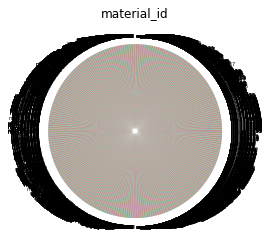

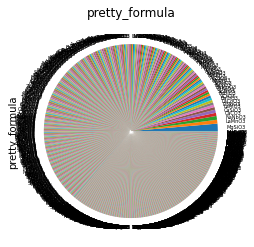

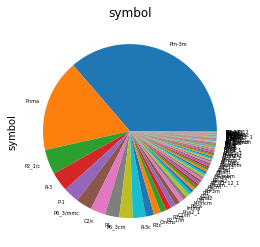

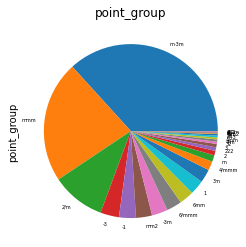

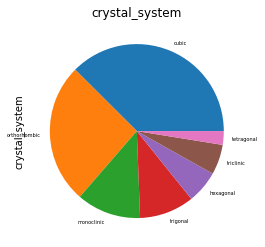

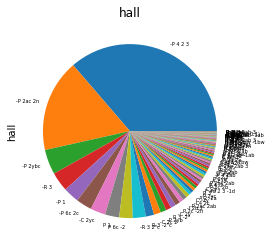

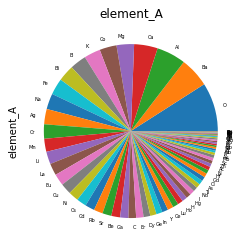

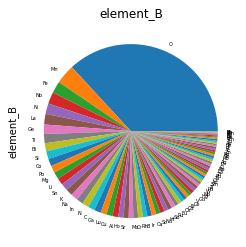

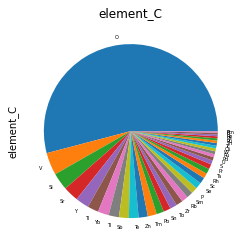

In [144]:
for col in mat_list0.select_dtypes('object'):
    plt.figure()
    mat_list0[col].value_counts().plot.pie(fontsize=5, title=col)

#### Stable materials
Materials that are within Convex Hull (e_above_hull, more stable than their competing phases).

In [53]:
mat_list1 = mat_list0[mat_list0['e_above_hull'] >= 0] # only elements with e_above_hull above zero, define new dataframe

In [54]:
mat_list1.describe() # there were already all above zero

,band_gap,formation_energy_per_atom,e_above_hull,number,a,b,c,alpha,beta,gamma,volume
count,2398.000000,2398.000000,2398.000000,2398.000000,2398.000000,2398.000000,2398.000000,2398.000000,2398.000000,2398.000000,2398.000000
mean,1.230595,-2.265419,0.242377,129.995413,5.259572,5.434720,7.049159,86.257185,87.462428,89.779141,227.716385
std,1.598627,0.869457,0.372420,85.860140,1.703934,1.768985,4.064019,12.513000,11.660245,15.734054,275.666811
min,0.000000,-4.037959,0.000000,1.000000,2.860253,2.865461,3.073034,26.513461,26.513461,19.427066,34.799143
25%,0.000000,-2.885303,0.018840,62.000000,4.009437,4.031818,4.072698,89.999706,90.000000,90.000000,68.332288
50%,0.097650,-2.336232,0.084684,148.000000,5.124582,5.379328,6.016576,90.000000,90.000000,90.000000,137.221363
75%,2.403725,-1.645397,0.330591,221.000000,5.718936,6.008352,8.343983,90.000000,90.000000,90.000000,268.738175
max,5.906300,1.978078,4.155444,227.000000,18.857954,17.059404,74.139073,137.098536,120.943854,151.082510,4158.237430


In [55]:
# Make a copy of the df
mat_list2 = mat_list1.copy()

In [56]:
mat_list2.head()

,material_id,pretty_formula,band_gap,formation_energy_per_atom,e_above_hull,symbol,number,point_group,crystal_system,hall,a,b,c,alpha,beta,gamma,volume,element_A,element_B,element_C
0,mp-1001571,CaFeO3,0.0000,-2.282308,0.052161,Pm-3m,221,m-3m,cubic,-P 4 2 3,3.836610,3.836610,3.836610,90.0,90.0,90.0,56.473274,Ca,Fe,O
1,mp-1016821,BaSiO3,1.0186,-2.852291,0.561269,Pm-3m,221,m-3m,cubic,-P 4 2 3,3.836937,3.836937,3.836937,90.0,90.0,90.0,56.487715,Ba,Si,O
2,mp-1016823,BaGeO3,0.0000,-2.473919,0.232358,Pm-3m,221,m-3m,cubic,-P 4 2 3,3.980389,3.980389,3.980389,90.0,90.0,90.0,63.063280,Ba,Ge,O
3,mp-1016828,CdIrO3,0.0000,-0.851737,0.463199,Pm-3m,221,m-3m,cubic,-P 4 2 3,3.953165,3.953165,3.953165,90.0,90.0,90.0,61.778139,Cd,Ir,O
4,mp-1016833,CaRhO3,0.0000,-1.851243,0.257081,Pm-3m,221,m-3m,cubic,-P 4 2 3,3.954209,3.954209,3.954209,90.0,90.0,90.0,61.827098,Ca,Rh,O


In [57]:
len(mat_list2) #df with more lines due to duplicates in fabrication process

2398

In [58]:
mat_list3 = mat_list2.drop_duplicates(subset=['material_id']) 
# let's drop the duplicates basing on the column material_id

In [59]:
len(mat_list3) # it was ok, no duplicates!

2398

In [60]:
mat_list3.dtypes

material_id                   object
pretty_formula                object
band_gap                     float64
formation_energy_per_atom    float64
e_above_hull                 float64
symbol                        object
number                         int64
point_group                   object
crystal_system                object
hall                          object
a                            float64
b                            float64
c                            float64
alpha                        float64
beta                         float64
gamma                        float64
volume                       float64
element_A                     object
element_B                     object
element_C                     object
dtype: object

2398 materials (<code>mat_list3</code>) fufill all the criteria desired:

- [x] Perovskite materials
- [x] e_hull > 0


Final df is:

In [61]:
mat_list3['pretty_formula'].values # the compounds

array(['CaFeO3', 'BaSiO3', 'BaGeO3', ..., 'ZnNiO3', 'ZnWO3', 'ZnWO3'],
      dtype=object)

#### Let's take one of them to study in depth: **TiPbO3**

In [62]:
selected_material = mat_list2[mat_list2['pretty_formula']=='TiPbO3'] 
# select all features of this material

In [63]:
selected_material

,material_id,pretty_formula,band_gap,formation_energy_per_atom,e_above_hull,symbol,number,point_group,crystal_system,hall,a,b,c,alpha,beta,gamma,volume,element_A,element_B,element_C
2162,mp-19845,TiPbO3,1.7601,-2.698645,0.041222,Pm-3m,221,m-3m,cubic,-P 4 2 3,3.969049,3.969049,3.969049,90.0,90.0,90.0,62.525818,Ti,Pb,O
2166,mp-20459,TiPbO3,1.9569,-2.739866,0.000000,P4mm,99,4mm,tetragonal,P 4 -2,3.861215,3.861215,4.627061,90.0,90.0,90.0,68.984766,Ti,Pb,O


In [64]:
selected = 'mp-20459' # ID Materials Project

In [65]:
selected_material.keys() # features

Index(['material_id', 'pretty_formula', 'band_gap',
       'formation_energy_per_atom', 'e_above_hull', 'symbol', 'number',
       'point_group', 'crystal_system', 'hall', 'a', 'b', 'c', 'alpha', 'beta',
       'gamma', 'volume', 'element_A', 'element_B', 'element_C'],
      dtype='object')

#### Electronic Structure **TiPbO3**

From Materials Project:

In [66]:
with MPRester(apikey) as mpr:
    bs = mpr.get_bandstructure_by_material_id(selected) # using MP id

/usr/local/lib/python3.8/dist-packages/pymatgen/ext/matproj.py:186: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(


In [67]:
bs.get_band_gap() # type of electronic transition

{'direct': False,
 'energy': 1.8242000000000003,
 'transition': 'X-(0.000,0.000,0.464)'}

In [68]:
efermi=bs.efermi
print(efermi)  # Fermi energy eV

4.72715899


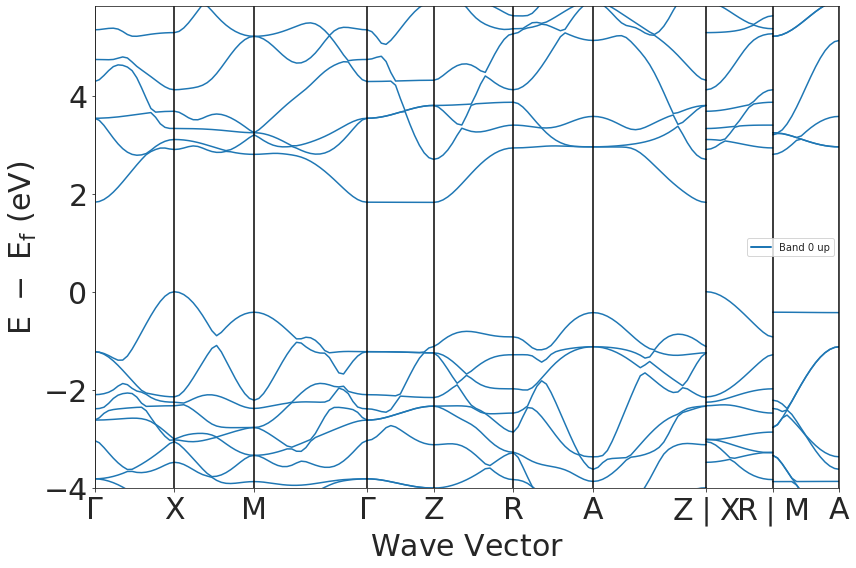

In [69]:
bsp = BSPlotter(bs)
bsp.get_plot(zero_to_efermi=True).show() # Pymatgen automatic plotting
#bsp.bs_plot_data(zero_to_efermi=True)   # Extract in the dict form to plot manually

### Crystal Structure **TiPbO3**

Downloaded from Materials Project (it is also possible to use <code>bs</code> to store the crystal structure information).

In [70]:
with MPRester(apikey) as mpr:
    structure = mpr.get_structure_by_material_id(selected)

/usr/local/lib/python3.8/dist-packages/pymatgen/ext/matproj.py:186: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(


In [71]:
structure.atomic_numbers

(22, 82, 8, 8, 8)

In [72]:
structure.cart_coords # atomic positions

array([[1.9306075 , 1.9306075 , 2.4103425 ],
       [0.        , 0.        , 4.48460305],
       [1.9306075 , 1.9306075 , 0.65912021],
       [0.        , 1.9306075 , 2.89958479],
       [1.9306075 , 0.        , 2.89958479]])

In [73]:
structure.lattice # lattice parameters

Lattice
    abc : 3.861215 3.861215 4.627061
 angles : 90.0 90.0 90.0
 volume : 68.98476581295094
      A : 3.861215 0.0 0.0
      B : 0.0 3.861215 0.0
      C : 0.0 0.0 4.627061
    pbc : True True True

### Lets use the `mat_list3` to find the polar structures (`target`!)

In [74]:
from pymatgen.symmetry.groups import SpaceGroup, SYMM_DATA, sg_symbol_from_int_number

### Selecting the polar groups

In [75]:
# This is a list of the point groups as noted in pymatgen
point_groups = []
for i in range(1,231):
    symbol = sg_symbol_from_int_number(i)
    point_groups.append(SYMM_DATA['space_group_encoding'][symbol]['point_group'])

# # Note that there are 40 of them, rather than 32.
print("Number of point groups denoted in pymatgen: ", len(set(point_groups)))

# This is because multiple conventions are used for the same point group.
# This dictionary can be used to convert between them.
point_group_conv = {'321' :'32', '312': '32', '3m1' :'3m', '31m': '3m',
                    '-3m1' : '-3m', '-31m': '-3m', '-4m2': '-42m', '-62m': '-6m2' }

# Using this dictionary we can correct to the standard point group notation.
corrected_point_groups = [point_group_conv.get(pg, pg) for pg in point_groups]
# Which produces the correct number of point groups. 32.
print("Number of point groups in conventional notation: ", len(set(corrected_point_groups)))

Number of point groups denoted in pymatgen:  40
Number of point groups in conventional notation:  32


In [76]:
# There are 10 polar point groups
polar_point_groups = ['1', '2', 'm', 'mm2', '4', '4mm', '3', '3m', '6', '6mm']

# Polar spacegroups have polar point groups.
polar_spacegroups = []
# There are 230 spacegroups
for i in range(1,231):
    symbol = sg_symbol_from_int_number(i)
    pg = SYMM_DATA['space_group_encoding'][symbol]['point_group']
    if point_group_conv.get(pg, pg) in polar_point_groups:
        polar_spacegroups.append(i)
        
# 68 of the 230 spacegroups are polar.
print("Number of polar spacegroups: ", len(polar_spacegroups))

Number of polar spacegroups:  68


In [77]:
# selecting the space groups that are polar
df_polar = mat_list3[mat_list3["number"].isin(polar_spacegroups)] 
df_polar.head()

,material_id,pretty_formula,band_gap,formation_energy_per_atom,e_above_hull,symbol,number,point_group,crystal_system,hall,a,b,c,alpha,beta,gamma,volume,element_A,element_B,element_C
26,mp-1076932,BaTiO3,0.0000,-2.522488,0.979015,Amm2,38,mm2,orthorhombic,A 2 -2,3.764402,3.764402,8.881493,90.000000,90.000000,90.214496,125.856288,Ba,O,Ti
44,mp-1178561,AgClO3,2.8464,-0.482895,0.062126,R3m,160,3m,trigonal,"R 3 -2""",4.324921,4.324921,4.324921,78.851462,78.851462,78.851455,76.844058,Ag,Cl,O
45,mp-1178562,AgBrO3,2.5145,-0.296269,0.001173,R3m,160,3m,trigonal,"R 3 -2""",4.464877,4.464877,4.464878,80.353693,80.353693,80.353690,85.613183,Ag,Br,O
55,mp-1182337,BaClO3,0.1709,-1.288107,0.497629,P1,1,1,triclinic,P 1,4.618091,4.923813,9.161635,78.570779,86.636369,87.404681,203.719558,Ba,Cl,O
145,mp-1205336,BaMnO3,1.8948,-2.494128,0.000000,P6_3mc,186,mm2,hexagonal,P 6c -2c,4.932068,5.804733,10.052276,90.000227,89.999994,90.000000,287.790008,Ba,Mn,O


In [78]:
df_polar[df_polar["number"] == 38] # checking for one polar structure

,material_id,pretty_formula,band_gap,formation_energy_per_atom,e_above_hull,symbol,number,point_group,crystal_system,hall,a,b,c,alpha,beta,gamma,volume,element_A,element_B,element_C
26,mp-1076932,BaTiO3,0.0000,-2.522488,0.979015,Amm2,38,mm2,orthorhombic,A 2 -2,3.764402,3.764402,8.881493,90.000000,90.000000,90.214496,125.856288,Ba,O,Ti
155,mp-1227991,BaInO3,0.0000,-2.139200,0.108299,Amm2,38,mm2,orthorhombic,A 2 -2,4.281840,4.281840,8.649932,90.000000,90.000000,90.683757,158.577870,Ba,In,O
321,mp-5777,BaTiO3,2.3733,-3.501030,0.000473,Amm2,38,mm2,orthorhombic,A 2 -2,4.122788,4.122788,3.987531,90.000000,90.000000,90.488241,67.775127,Ba,Ti,O
330,mp-644497,BaTiO3,0.5466,-2.787271,0.714232,Amm2,38,mm2,orthorhombic,A 2 -2,5.555777,5.555777,3.784210,90.000000,90.000000,107.264147,111.543408,Ba,Ti,O
447,mp-995191,BaTiO3,0.0000,-1.694888,1.806615,Amm2,38,mm2,orthorhombic,A 2 -2,4.120883,4.120883,5.032511,90.000000,90.000000,90.406708,85.458324,Ba,Ti,O
815,mp-5246,KNbO3,2.1256,-2.865365,0.000134,Amm2,38,mm2,orthorhombic,A 2 -2,4.130661,4.130661,4.017551,90.000000,90.000000,90.352173,68.547603,K,Nb,O
1670,mp-1281764,SrCoO3,0.0000,-2.001234,0.037374,Amm2,38,mm2,orthorhombic,A 2 -2,5.490196,6.736160,6.736086,70.943697,90.000156,90.000144,235.467347,Co,O,Sr
2165,mp-20337,ZrPbO3,3.2477,-2.852447,0.032541,Amm2,38,mm2,orthorhombic,A 2 -2,4.276791,4.276791,4.176356,90.000000,90.000000,91.634838,76.358380,Zr,Pb,O
2397,mvc-5731,ZnWO3,0.0000,-1.328743,0.563319,Amm2,38,mm2,orthorhombic,A 2 -2,3.997302,3.997302,4.072086,90.000000,90.000000,91.018256,65.055250,O,W,Zn


In [79]:
# selecting the space group that are not polar
df_non_polar = mat_list3[~mat_list3["number"].isin(polar_spacegroups)] 
df_non_polar.head()

,material_id,pretty_formula,band_gap,formation_energy_per_atom,e_above_hull,symbol,number,point_group,crystal_system,hall,a,b,c,alpha,beta,gamma,volume,element_A,element_B,element_C
0,mp-1001571,CaFeO3,0.0000,-2.282308,0.052161,Pm-3m,221,m-3m,cubic,-P 4 2 3,3.836610,3.836610,3.836610,90.0,90.0,90.0,56.473274,Ca,Fe,O
1,mp-1016821,BaSiO3,1.0186,-2.852291,0.561269,Pm-3m,221,m-3m,cubic,-P 4 2 3,3.836937,3.836937,3.836937,90.0,90.0,90.0,56.487715,Ba,Si,O
2,mp-1016823,BaGeO3,0.0000,-2.473919,0.232358,Pm-3m,221,m-3m,cubic,-P 4 2 3,3.980389,3.980389,3.980389,90.0,90.0,90.0,63.063280,Ba,Ge,O
3,mp-1016828,CdIrO3,0.0000,-0.851737,0.463199,Pm-3m,221,m-3m,cubic,-P 4 2 3,3.953165,3.953165,3.953165,90.0,90.0,90.0,61.778139,Cd,Ir,O
4,mp-1016833,CaRhO3,0.0000,-1.851243,0.257081,Pm-3m,221,m-3m,cubic,-P 4 2 3,3.954209,3.954209,3.954209,90.0,90.0,90.0,61.827098,Ca,Rh,O


In [80]:
print(df_polar.shape, df_non_polar.shape) # unbalenced data!

(337, 20) (2061, 20)


Our polar and non-polar data is unbalanced (much more non-polar than polar...)

Lets take a sample of the non-polar using `sample`

In [81]:
df_non_polar_balanced = df_non_polar.sample(df_polar.shape[0])
df_non_polar_balanced.head()

,material_id,pretty_formula,band_gap,formation_energy_per_atom,e_above_hull,symbol,number,point_group,crystal_system,hall,a,b,c,alpha,beta,gamma,volume,element_A,element_B,element_C
1844,mp-754696,PrTiO3,0.0000,-3.493651,0.104697,Pm-3m,221,m-3m,cubic,-P 4 2 3,3.943236,3.943236,3.943236,90.0,90.0,90.0,61.313811,Pr,Ti,O
2260,mp-755109,YErO3,4.5415,-3.925785,0.097525,Pnma,62,mmm,orthorhombic,-P 2ac 2n,5.682581,5.943749,8.375170,90.0,90.0,90.0,282.878361,Er,O,Y
1975,mp-978493,SiSnO3,1.0352,-2.138944,0.486249,Pm-3m,221,m-3m,cubic,-P 4 2 3,3.712219,3.712219,3.712219,90.0,90.0,90.0,51.156493,Si,Sn,O
2274,mp-755865,TbNiO3,0.0000,-2.427882,0.000000,Pnma,62,mmm,orthorhombic,-P 2ac 2n,5.226156,5.578493,7.491863,90.0,90.0,90.0,218.418333,Ni,O,Tb
1148,mp-1186154,NaNiO3,0.0000,-0.685418,0.316557,Pm-3m,221,m-3m,cubic,-P 4 2 3,3.821156,3.821156,3.821156,90.0,90.0,90.0,55.793590,Na,Ni,O


In [82]:
df_non_polar_balanced.shape, df_polar.shape

((337, 20), (337, 20))

### Creating Target (`polar`) column
- we can see that the structure is directly related to the polarity
- for ex.: the non-polar df has no "cubic" value, whereas the polar does
- to account for this, we need to exclude the columns: `symbol`, `number`, `point_group`, `hall`
- we will then add a column called `polar` and add values of `1` if it is polar and of `0` if is non polar

In [83]:
df_non_polar_balanced[df_non_polar_balanced["crystal_system"] == "monoclinic"].head()

,material_id,pretty_formula,band_gap,formation_energy_per_atom,e_above_hull,symbol,number,point_group,crystal_system,hall,a,b,c,alpha,beta,gamma,volume,element_A,element_B,element_C
1364,mp-696822,LiNO3,0.0000,-0.356050,1.117051,C2/c,15,2/m,monoclinic,-C 2yc,5.135315,5.135315,3.950154,70.422435,70.422435,86.908583,92.274955,Li,N,O
1199,mp-1289597,MnBO3,1.1167,-2.420533,0.017001,C2/c,15,-1,monoclinic,-C 2yc,4.760708,8.054168,5.920814,106.400134,61.560451,92.507223,190.394848,B,Mn,O
999,mvc-12804,EuCuO3,0.0000,-1.981771,0.083335,C2/c,15,2/m,monoclinic,-C 2yc,8.089776,8.089776,6.304161,70.405926,70.405926,47.041991,281.022849,Cu,Eu,O
1277,mp-4321,MgSiO3,4.5343,-3.228042,0.017551,C2/c,15,2/m,monoclinic,-C 2yc,6.533922,6.533922,5.059958,80.588170,80.588170,86.486735,210.111169,Mg,Si,O
300,mp-558637,AgTeO3,1.6613,-1.137206,0.020452,P2_1/c,14,2/m,monoclinic,-P 2ybc,11.826693,6.024564,9.221229,61.033231,90.000000,90.000000,574.826171,Ag,O,Te


In [84]:
df_polar[df_polar["crystal_system"] == "monoclinic"].head()

,material_id,pretty_formula,band_gap,formation_energy_per_atom,e_above_hull,symbol,number,point_group,crystal_system,hall,a,b,c,alpha,beta,gamma,volume,element_A,element_B,element_C
167,mp-1261047,AlSbO3,3.8402,-2.535147,0.063172,P2_1,4,2,monoclinic,P 2yb,5.503218,5.118104,11.530310,90.040209,89.917276,90.079395,324.762472,Al,O,Sb
178,mp-17008,CaTeO3,3.2993,-2.408547,0.010153,P2_1,4,2,monoclinic,P 2yb,5.748211,8.770250,11.499994,69.436998,90.000000,90.000000,542.814056,Ca,O,Te
312,mp-561412,CaCO3,4.9963,-2.691594,0.007193,C2,5,2,monoclinic,C 2y,5.040837,5.040837,8.744578,89.354532,89.354532,59.596678,191.627928,Ca,C,O
381,mp-762225,BaCO3,4.4740,-2.679561,0.013233,P2_1,4,2,monoclinic,P 2yb,5.403903,4.580137,6.982293,72.642135,90.000000,90.000000,164.946001,Ba,C,O
382,mp-765647,AlVO3,1.1510,-2.897642,0.084466,Cm,8,m,monoclinic,C -2y,13.213680,13.213680,5.837209,77.302734,77.302734,25.710583,430.764943,Al,O,V


In [85]:
df_polar = df_polar.drop(["symbol", "number", "point_group", "hall"], axis=1)
df_polar["polar"] = 1
df_polar.head()

,material_id,pretty_formula,band_gap,formation_energy_per_atom,e_above_hull,crystal_system,a,b,c,alpha,beta,gamma,volume,element_A,element_B,element_C,polar
26,mp-1076932,BaTiO3,0.0000,-2.522488,0.979015,orthorhombic,3.764402,3.764402,8.881493,90.000000,90.000000,90.214496,125.856288,Ba,O,Ti,1
44,mp-1178561,AgClO3,2.8464,-0.482895,0.062126,trigonal,4.324921,4.324921,4.324921,78.851462,78.851462,78.851455,76.844058,Ag,Cl,O,1
45,mp-1178562,AgBrO3,2.5145,-0.296269,0.001173,trigonal,4.464877,4.464877,4.464878,80.353693,80.353693,80.353690,85.613183,Ag,Br,O,1
55,mp-1182337,BaClO3,0.1709,-1.288107,0.497629,triclinic,4.618091,4.923813,9.161635,78.570779,86.636369,87.404681,203.719558,Ba,Cl,O,1
145,mp-1205336,BaMnO3,1.8948,-2.494128,0.000000,hexagonal,4.932068,5.804733,10.052276,90.000227,89.999994,90.000000,287.790008,Ba,Mn,O,1


In [86]:
df_non_polar_balanced = df_non_polar_balanced.drop(["symbol", "number", "point_group", "hall"], axis=1)
df_non_polar_balanced["polar"] = 0
df_non_polar_balanced.head()

,material_id,pretty_formula,band_gap,formation_energy_per_atom,e_above_hull,crystal_system,a,b,c,alpha,beta,gamma,volume,element_A,element_B,element_C,polar
1844,mp-754696,PrTiO3,0.0000,-3.493651,0.104697,cubic,3.943236,3.943236,3.943236,90.0,90.0,90.0,61.313811,Pr,Ti,O,0
2260,mp-755109,YErO3,4.5415,-3.925785,0.097525,orthorhombic,5.682581,5.943749,8.375170,90.0,90.0,90.0,282.878361,Er,O,Y,0
1975,mp-978493,SiSnO3,1.0352,-2.138944,0.486249,cubic,3.712219,3.712219,3.712219,90.0,90.0,90.0,51.156493,Si,Sn,O,0
2274,mp-755865,TbNiO3,0.0000,-2.427882,0.000000,orthorhombic,5.226156,5.578493,7.491863,90.0,90.0,90.0,218.418333,Ni,O,Tb,0
1148,mp-1186154,NaNiO3,0.0000,-0.685418,0.316557,cubic,3.821156,3.821156,3.821156,90.0,90.0,90.0,55.793590,Na,Ni,O,0


### Merging and then shuffling the two dfs (polar and non-polar)

In [87]:
# merging the two dfs polar and non_polar_balanced
df = pd.concat([df_polar, df_non_polar_balanced], axis=0, ignore_index=True)
df

,material_id,pretty_formula,band_gap,formation_energy_per_atom,e_above_hull,crystal_system,a,b,c,alpha,beta,gamma,volume,element_A,element_B,element_C,polar
0,mp-1076932,BaTiO3,0.0000,-2.522488,0.979015,orthorhombic,3.764402,3.764402,8.881493,90.000000,90.000000,90.214496,125.856288,Ba,O,Ti,1
1,mp-1178561,AgClO3,2.8464,-0.482895,0.062126,trigonal,4.324921,4.324921,4.324921,78.851462,78.851462,78.851455,76.844058,Ag,Cl,O,1
2,mp-1178562,AgBrO3,2.5145,-0.296269,0.001173,trigonal,4.464877,4.464877,4.464878,80.353693,80.353693,80.353690,85.613183,Ag,Br,O,1
3,mp-1182337,BaClO3,0.1709,-1.288107,0.497629,triclinic,4.618091,4.923813,9.161635,78.570779,86.636369,87.404681,203.719558,Ba,Cl,O,1
4,mp-1205336,BaMnO3,1.8948,-2.494128,0.000000,hexagonal,4.932068,5.804733,10.052276,90.000227,89.999994,90.000000,287.790008,Ba,Mn,O,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,mp-1186997,SiMoO3,0.0000,-1.701170,0.906716,cubic,3.645503,3.645503,3.645503,90.000000,90.000000,90.000000,48.447613,Mo,O,Si,0
670,mp-1184486,GdErO3,0.3671,-3.250530,0.737228,cubic,4.241146,4.241146,4.241146,90.000000,90.000000,90.000000,76.286848,Er,Gd,O,0
671,mvc-3844,AlAgO3,0.0315,-1.748860,0.162507,orthorhombic,4.727991,5.293314,9.496944,90.000000,90.000000,90.000000,237.677557,Ag,Al,O,0
672,mvc-13858,YAgO3,0.0063,-2.104512,0.079118,orthorhombic,5.493739,6.027972,7.937536,90.000000,90.000000,90.000000,262.860275,Ag,O,Y,0


In [88]:
# shuffling the final df
df = df.sample(frac=1, random_state=66)
df

,material_id,pretty_formula,band_gap,formation_energy_per_atom,e_above_hull,crystal_system,a,b,c,alpha,beta,gamma,volume,element_A,element_B,element_C,polar
330,mvc-3765,YCoO3,0.7551,-2.512732,0.148475,hexagonal,6.165754,6.165754,11.428332,90.000000,90.000000,120.000004,376.258136,Co,O,Y,1
654,mp-1183712,CrGeO3,0.0000,-1.469240,0.661529,cubic,3.743292,3.743292,3.743292,90.000000,90.000000,90.000000,52.451887,Cr,Ge,O,0
396,mp-776165,AgAuO3,0.2565,-0.368103,0.058891,cubic,7.285926,7.285926,7.285926,60.000000,60.000000,60.000000,273.488677,Ag,Au,O,0
176,mp-608595,NaBrO3,0.0753,-0.488710,0.525407,monoclinic,7.536830,7.749286,7.387425,89.949612,89.695885,89.809752,431.454301,Br,Na,O,1
590,mvc-13964,TiAlO3,0.0000,-3.116338,0.257922,hexagonal,3.180333,3.180333,12.059897,90.000000,90.000000,119.999981,105.637845,Al,O,Ti,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,mp-1245147,CrFeO3,0.4802,-1.685922,0.458440,triclinic,10.021261,10.936568,9.347079,91.270394,93.004555,89.385670,1022.716472,Cr,Fe,O,1
122,mp-766236,GdErO3,3.2340,-3.987759,0.000000,monoclinic,9.278831,9.278831,10.712979,54.730018,54.730018,70.524660,614.816526,Er,Gd,O,1
51,mvc-3506,AlSbO3,1.2677,-2.192218,0.406101,hexagonal,5.679464,5.679464,13.101949,90.000000,90.000000,119.999999,366.000121,Al,O,Sb,1
631,mp-1040469,KMoO3,0.0000,-2.121731,0.105528,cubic,4.004820,4.004820,4.004820,90.000000,90.000000,90.000000,64.231639,K,Mo,O,0


### Exploring graphically the preprocced `df`

#### 1) **Bandgap dispersion** as function of lattice parameters `a`, `b` and `c`

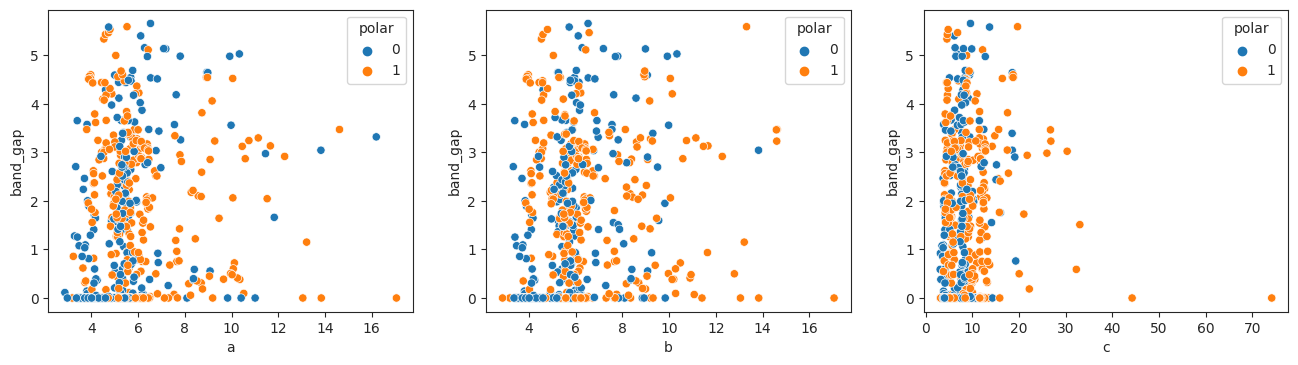

In [89]:
fig, ax = plt.subplots(1,3, figsize=(16,4), dpi=100) # Cria a imagem com 1 linha e 3 colunas (subplots)

data = df
y = "band_gap"
hue = "polar"

sns.scatterplot(data=data, x="a", y=y, hue=hue, ax=ax[0])
sns.scatterplot(data=data, x="b", y=y, hue=hue, ax=ax[1])
sns.scatterplot(data=data, x="c", y=y, hue=hue, ax=ax[2])

#### 2) **Bandgap dispersion** as a function of lattice angles `alpha`, `beta` and `gamma`

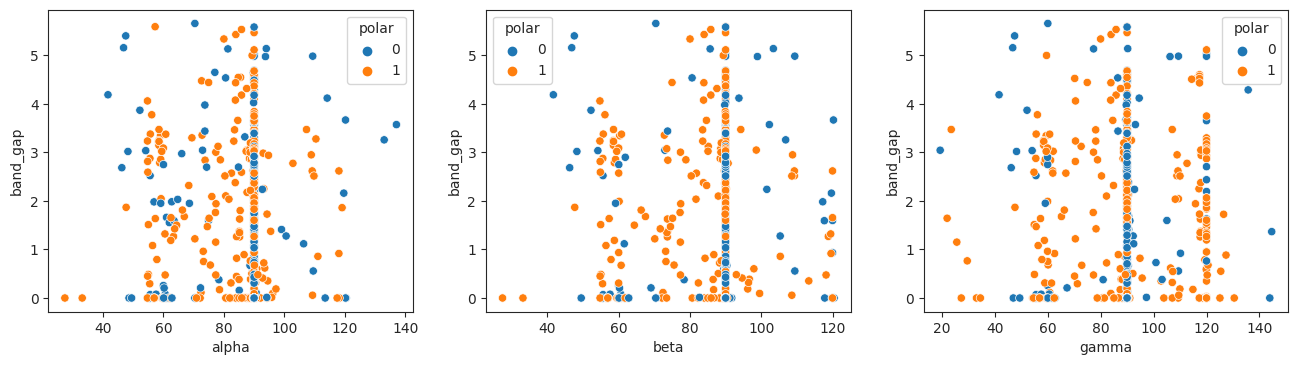

In [90]:
fig, ax = plt.subplots(1,3, figsize=(16,4), dpi=100) # Cria a imagem com 1 linha e 3 colunas (subplots)

data = df
y = "band_gap"
hue = "polar"

sns.scatterplot(data=data, x="alpha", y=y, hue=hue, ax=ax[0])
sns.scatterplot(data=data, x="beta", y=y, hue=hue, ax=ax[1])
sns.scatterplot(data=data, x="gamma", y=y, hue=hue, ax=ax[2])

#### 3) **Bandgap** as function of atom position in perovskite structure $ABC_3$:

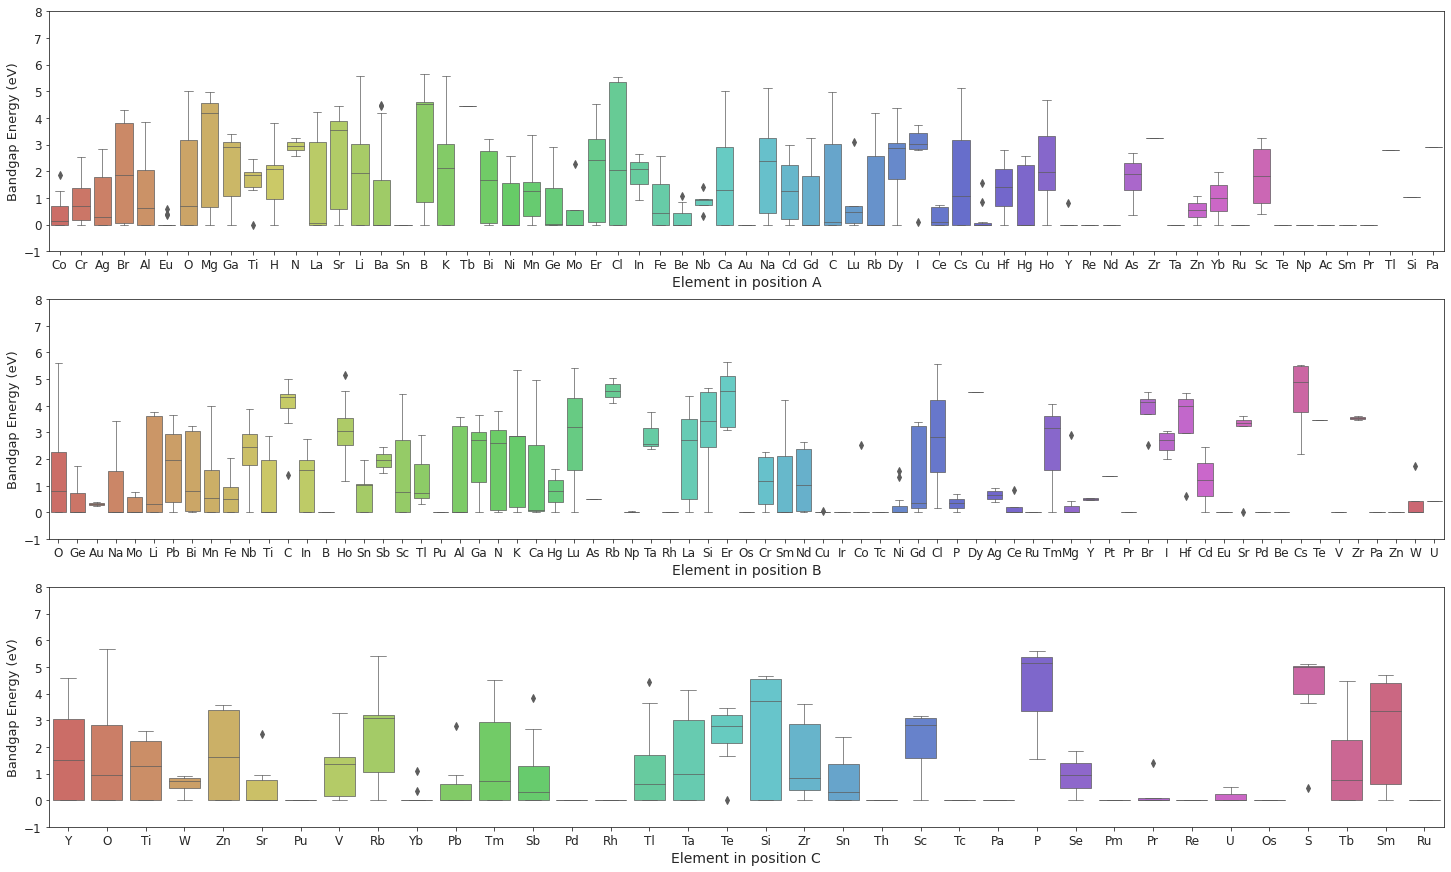

In [91]:
fig, axes = plt.subplots(3, 1, figsize=(25, 15))

data = df
y = "band_gap"

sns.boxplot(x="element_A", y=y, data=data,
            palette="hls", linewidth=0.7, ax=axes[0],
            order=list(dict.fromkeys(df["element_A"].tolist())),
           )

sns.boxplot(x="element_B", y=y, data=data, 
            palette="hls", linewidth=0.7, ax=axes[1],
            order=list(dict.fromkeys(df["element_B"].tolist())),
           )

sns.boxplot(x="element_C", y=y, data=data,
            palette="hls", linewidth=0.7, ax=axes[2],
            order=list(dict.fromkeys(df["element_C"].tolist())),
           )

### Ajustes
axes[0].set_xlabel('Element in position A',  fontsize=14)
axes[1].set_xlabel('Element in position B',  fontsize=14)
axes[2].set_xlabel('Element in position C',  fontsize=14)

axes[0].set_ylim([-1,8])
axes[1].set_ylim([-1,8])
axes[2].set_ylim([-1,8])

axes[0].set_ylabel('Bandgap Energy (eV)',  fontsize=13)
axes[1].set_ylabel('Bandgap Energy (eV)',  fontsize=13)
axes[2].set_ylabel('Bandgap Energy (eV)',  fontsize=13)

axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[0].tick_params(axis='both', which='minor', labelsize=16)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[1].tick_params(axis='both', which='minor', labelsize=16)
axes[2].tick_params(axis='both', which='major', labelsize=12)
axes[2].tick_params(axis='both', which='minor', labelsize=16)

plt.subplots_adjust(wspace=0.6)
#plt.savefig('bandgap_boxplot.png', transparent=True) Para salvar a imagem

#### 4) Polar or non-polar materials

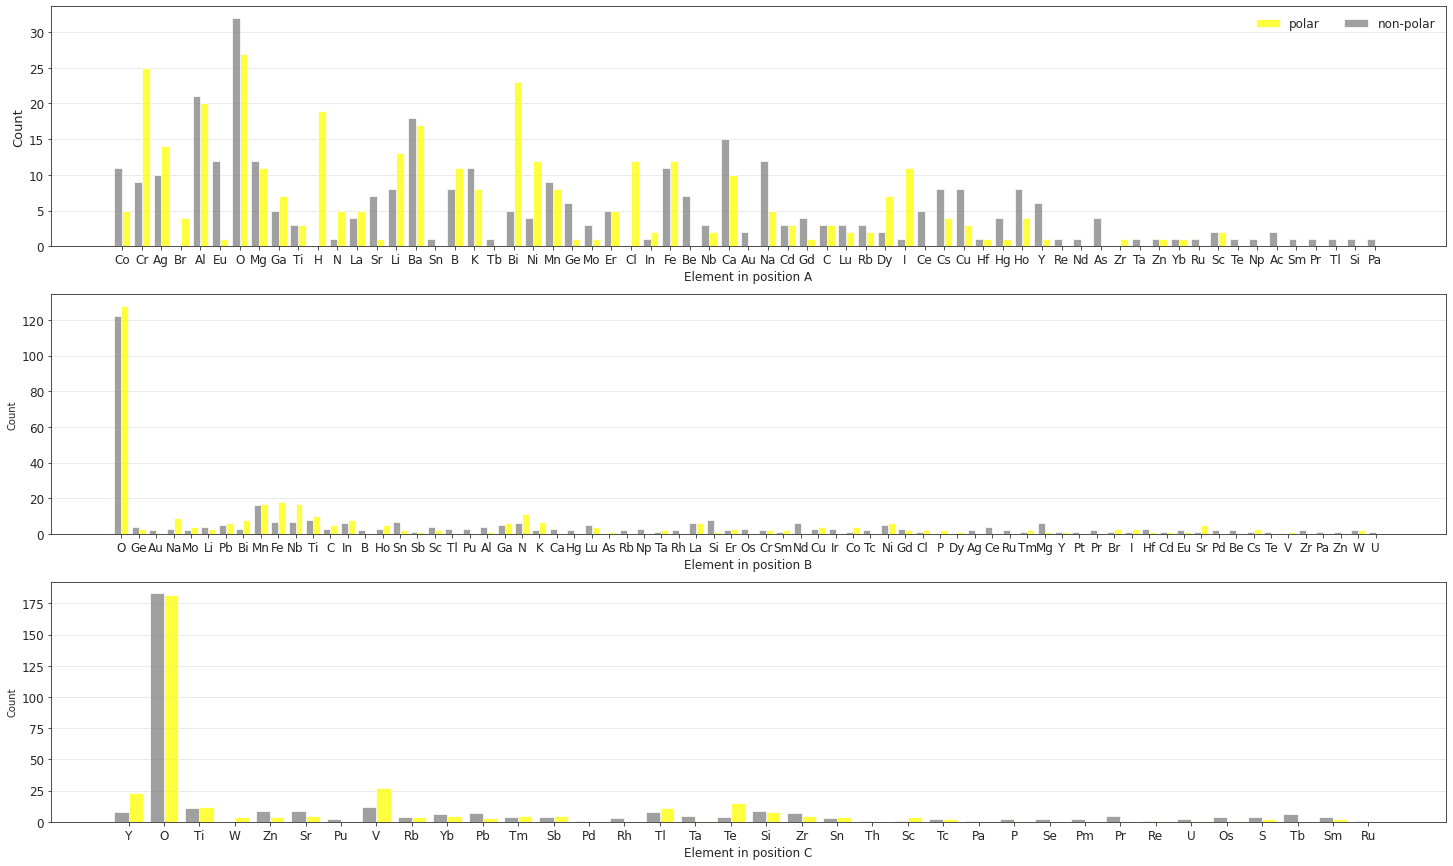

In [92]:
dados2 = df.copy()

dados2['A'] =  pd.Categorical(dados2['element_A'], list(dict.fromkeys(df["element_A"].tolist())))
dados2['B'] =  pd.Categorical(dados2['element_B'], list(dict.fromkeys(df["element_B"].tolist())))
dados2['C'] =  pd.Categorical(dados2['element_C'], list(dict.fromkeys(df["element_C"].tolist())))

fig, axes = plt.subplots(3, 1, figsize=(25, 15))


sns.histplot(x="A",hue="polar",
            palette=["grey", "yellow"], linewidth=0.7, ax=axes[0],
            data=dados2, multiple="dodge", shrink=.8, legend=None
           )

sns.histplot(x="B", hue="polar",
            palette=["grey", "yellow"], linewidth=0.7, ax=axes[1],
            data=dados2, multiple="dodge", shrink=.8, legend=None
           )

sns.histplot(x="C", hue="polar",
            palette=["grey", "yellow"], linewidth=0.7, ax=axes[2],
            data=dados2, multiple="dodge", shrink=.8, legend=None
           )


axes[0].grid(axis='y', alpha=0.5)
axes[1].grid(axis='y', alpha=0.5)
axes[2].grid(axis='y', alpha=0.5)

axes[0].set_xlabel('Element in position A',  fontsize=12)
axes[1].set_xlabel('Element in position B',  fontsize=12)
axes[2].set_xlabel('Element in position C',  fontsize=12)

axes[0].set_ylabel('Count',  fontsize=13)

axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[1].tick_params(axis='both', which='minor', labelsize=16)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[2].tick_params(axis='both', which='major', labelsize=12)

plt.subplots_adjust(wspace=0.05)
axes[0].legend(labels = ['polar', 'non-polar'],
          #  bbox_to_anchor =(0.25, 1.20),
           frameon=False, labelspacing=1, fontsize=12, ncol=2)

#### 5) General **features correlation**:

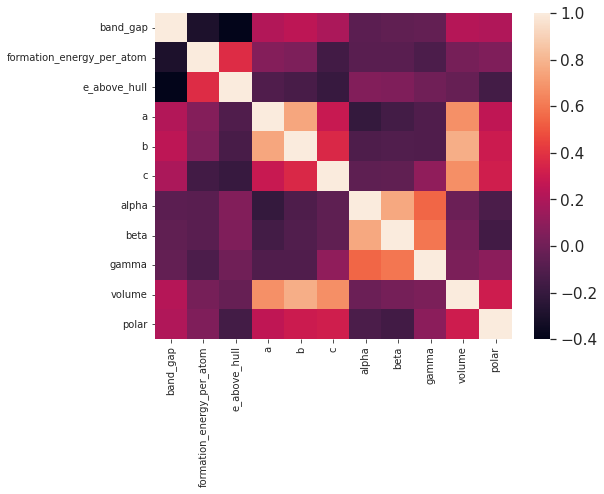

In [93]:
plt.subplots(figsize=(8,6))
sns.set(font_scale=1.4)
sns.heatmap(df.corr())

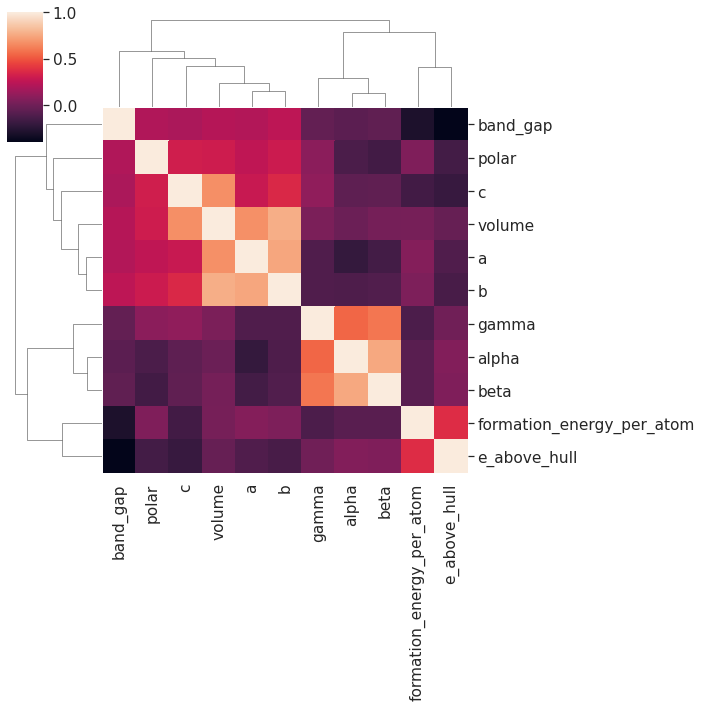

In [94]:
sns.set(font_scale=1.4)
sns.clustermap(df.corr())

# Part 3 - Modeling - Machine Learning Project

- Predict if a perovskite material is polar or non-polar (binary classification), given some of its crystalline structure (lattice params, angles, Bravais lattice) and its electronic and thermo properties (bandgap, stabilization energy...)

We will have one train set with:
- alloy ID (column `material`)
- its features: 
    - Quantitative features:  
    `band_gap`,
    
    `formation_energy_per_atom`: thermo energy
    
    `e_above_hull`: if > 0 stable

    `a`, `b`, `c`: crystal lattice parameters
    
    `alpha`, `beta`,	`gamma`: crystal lattice angles

    `volume`

    - Qualitative features:

    `material`: ID name

    `element_A`, `element_B`, `element_C`: elements in the perovskite ABC3

    `pretty_formula`: material's chemical formula

    `crystal_system`: cubic, ortho, mono...
    
- the `y`true labels: `polar` (1 for polar, 0 for non-polar)

In [95]:
df.head()

,material_id,pretty_formula,band_gap,formation_energy_per_atom,e_above_hull,crystal_system,a,b,c,alpha,beta,gamma,volume,element_A,element_B,element_C,polar
330,mvc-3765,YCoO3,0.7551,-2.512732,0.148475,hexagonal,6.165754,6.165754,11.428332,90.000000,90.000000,120.000004,376.258136,Co,O,Y,1
654,mp-1183712,CrGeO3,0.0000,-1.469240,0.661529,cubic,3.743292,3.743292,3.743292,90.000000,90.000000,90.000000,52.451887,Cr,Ge,O,0
396,mp-776165,AgAuO3,0.2565,-0.368103,0.058891,cubic,7.285926,7.285926,7.285926,60.000000,60.000000,60.000000,273.488677,Ag,Au,O,0
176,mp-608595,NaBrO3,0.0753,-0.488710,0.525407,monoclinic,7.536830,7.749286,7.387425,89.949612,89.695885,89.809752,431.454301,Br,Na,O,1
590,mvc-13964,TiAlO3,0.0000,-3.116338,0.257922,hexagonal,3.180333,3.180333,12.059897,90.000000,90.000000,119.999981,105.637845,Al,O,Ti,0


### Converting strings into Pandas Categories

In [96]:
# Make a copy
df_tmp = df.copy() 

In [97]:
df_tmp.head().T

,330,654,396,176,590
material_id,mvc-3765,mp-1183712,mp-776165,mp-608595,mvc-13964
pretty_formula,YCoO3,CrGeO3,AgAuO3,NaBrO3,TiAlO3
band_gap,0.7551,0.0,0.2565,0.0753,0.0
formation_energy_per_atom,-2.512732,-1.46924,-0.368103,-0.48871,-3.116338
e_above_hull,0.148475,0.661529,0.058891,0.525407,0.257922
crystal_system,hexagonal,cubic,cubic,monoclinic,hexagonal
a,6.165754,3.743292,7.285926,7.53683,3.180333
b,6.165754,3.743292,7.285926,7.749286,3.180333
c,11.428332,3.743292,7.285926,7.387425,12.059897
alpha,90.0,90.0,60.0,89.949612,90.0


In [98]:
# Find the columns which contain strings
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

material_id
pretty_formula
crystal_system
element_A
element_B
element_C


In [99]:
df_tmp.select_dtypes("object").columns

Index(['material_id', 'pretty_formula', 'crystal_system', 'element_A',
       'element_B', 'element_C'],
      dtype='object')

In [100]:
# This will turn all of the string values into category values
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered()

In [101]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 674 entries, 330 to 20
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   material_id                674 non-null    category
 1   pretty_formula             674 non-null    category
 2   band_gap                   674 non-null    float64 
 3   formation_energy_per_atom  674 non-null    float64 
 4   e_above_hull               674 non-null    float64 
 5   crystal_system             674 non-null    category
 6   a                          674 non-null    float64 
 7   b                          674 non-null    float64 
 8   c                          674 non-null    float64 
 9   alpha                      674 non-null    float64 
 10  beta                       674 non-null    float64 
 11  gamma                      674 non-null    float64 
 12  volume                     674 non-null    float64 
 13  element_A                  674 non

In [102]:
# saves the categories inside a dictionary for later
cat_pretty_formula = dict(enumerate(df_tmp['pretty_formula'].cat.categories))

### Converting categories to numbers

In [103]:
# Turns categorical varibles into numbers and fill missing
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        df_tmp[label] = pd.Categorical(content).codes +1 # so all numbers are positive

In [104]:
df_tmp.info() # they are all bool, float or int

<class 'pandas.core.frame.DataFrame'>
Int64Index: 674 entries, 330 to 20
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   material_id                674 non-null    int16  
 1   pretty_formula             674 non-null    int16  
 2   band_gap                   674 non-null    float64
 3   formation_energy_per_atom  674 non-null    float64
 4   e_above_hull               674 non-null    float64
 5   crystal_system             674 non-null    int8   
 6   a                          674 non-null    float64
 7   b                          674 non-null    float64
 8   c                          674 non-null    float64
 9   alpha                      674 non-null    float64
 10  beta                       674 non-null    float64
 11  gamma                      674 non-null    float64
 12  volume                     674 non-null    float64
 13  element_A                  674 non-null    int8  

### Save preprocessed data to a new .csv

In [105]:
# Export current tmp dataframe
# df_tmp.to_csv("drive/MyDrive/df_tmp.csv",
#              index=False)

In [106]:
# Import preprocessed data
df_tmp = pd.read_csv("drive/MyDrive/df_tmp.csv",
               low_memory=False)

In [107]:
df_tmp.head()

,material_id,pretty_formula,band_gap,formation_energy_per_atom,e_above_hull,crystal_system,a,b,c,alpha,beta,gamma,volume,element_A,element_B,element_C,polar
0,659,427,0.7551,-2.512732,0.148475,2,6.165754,6.165754,11.428332,90.000000,90.000000,120.000004,376.258136,15,45,33,1
1,589,414,0.3286,-2.949918,0.000000,1,4.357716,4.357716,4.357716,90.000000,90.000000,90.000000,82.751670,56,66,1,0
2,94,91,0.0000,-0.776441,0.971205,1,3.916935,3.916935,3.916935,90.000000,90.000000,90.000000,60.095104,16,45,12,0
3,397,280,0.0753,-0.488710,0.525407,3,7.536830,7.749286,7.387425,89.949612,89.695885,89.809752,431.454301,9,41,1,1
4,568,24,0.0000,-1.943559,0.155794,3,6.631048,6.631048,5.344552,81.568585,98.431415,92.495299,229.893563,3,45,6,0


### Splitting data into X and y (features and labels)

In [108]:
# Split data into X and y (features and labels)
X, y = df_tmp.drop("polar", axis=1), df_tmp["polar"]

X.shape, y.shape

((674, 16), (674,))

### Splitting X and y into train and test sets 

In [109]:
# Creating traina and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

print('Train set:', X_train.shape)
print('Test set:', X_test.shape)

Train set: (539, 16)
Test set: (135, 16)


### Creating an **evaluation** function
- Lets define as objective the following metrics: 
  - **F1 of at least 50%**
  - **Recall of at least 70%**

Remenber that:
- Precision: allows to reduce the as much as possible the false positives
- Recall (sensitivity): allows to reduce as much as possible the false negatives 
- Score F1: ratio between recall and performance

In [110]:
# Lets create an evaluation function that is going to contain multiple evalutation metrics
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve #overfitting ou underfitting

def evaluation(model, X_train, y_train, X_test, y_test, cv=4, scoring='f1', figsize=(12,8)):
  """
  Takes a model, trains it and predicts ypred. Then, evaluates the model using:
  - learning curve(model, X_train, y_train, cv=cv, scoring=scoring, train_sizes=np.linspace(0.1, 1, 10))
  - classficiation report(y_test, ypred)
  - confusion matrix(y_test, ypred)
  """
  model.fit(X_train, y_train)
  ypred = model.predict(X_test)
  
  print(confusion_matrix(y_test, ypred))
  print(classification_report(y_test, ypred))
  
  #N = nombre d'ech pour entrainer le model
  N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=cv, 
                                              scoring=scoring,
                                              train_sizes=np.linspace(0.1, 1, 10))
  plt.figure(figsize=figsize)
  plt.plot(N, train_score.mean(axis=1), label='train score')
  plt.plot(N, val_score.mean(axis=1), label='val score')
  plt.legend()




### Simple model 1 = DecisionTreeClassifier (overfitting...)

In [111]:
from sklearn.tree import DecisionTreeClassifier

In [112]:
simple_model = DecisionTreeClassifier(random_state=11)

[[56 12]
 [16 51]]
              precision    recall  f1-score   support

           0       0.78      0.82      0.80        68
           1       0.81      0.76      0.78        67

    accuracy                           0.79       135
   macro avg       0.79      0.79      0.79       135
weighted avg       0.79      0.79      0.79       135



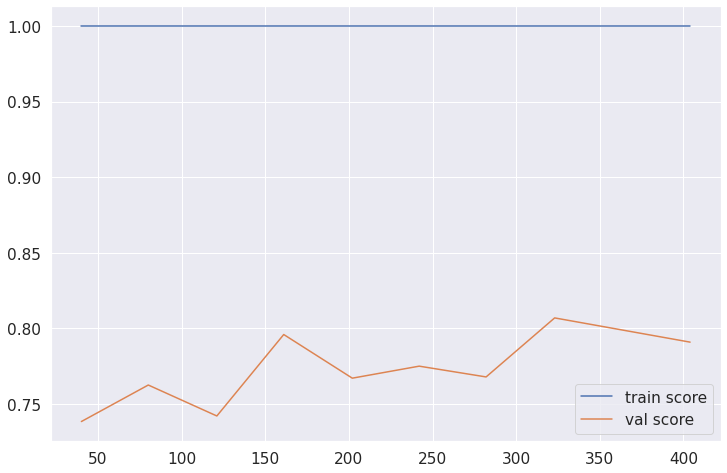

In [114]:
evaluation(simple_model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, cv=4, scoring='f1')

#### Checking the feature importance of this simple_model

In [280]:
# simple_model.feature_importances_
pd.DataFrame(simple_model.feature_importances_, index=X_train.columns)

,0
material_id,0.025847
pretty_formula,0.022200
band_gap,0.021905
formation_energy_per_atom,0.026295
e_above_hull,0.030020
crystal_system,0.286349
a,0.084268
b,0.101154
c,0.021989
alpha,0.022390


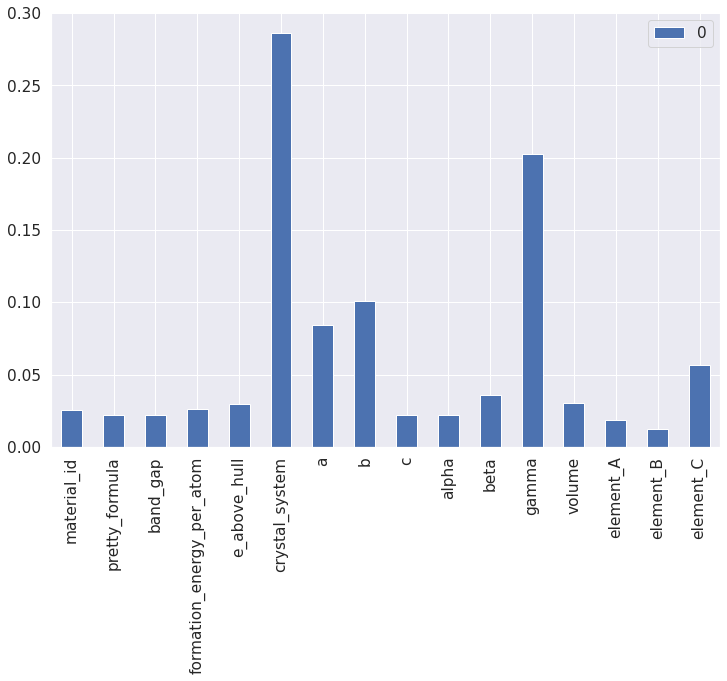

In [281]:
pd.DataFrame(simple_model.feature_importances_, 
             index=X_train.columns).plot.bar(figsize=(12,8))

### Simple model 2 = RandomForestClassifier

In [282]:
from sklearn.ensemble import RandomForestClassifier

In [284]:
simple_model2 = RandomForestClassifier(random_state=11)

[[63  7]
 [ 5 60]]
              precision    recall  f1-score   support

           0       0.93      0.90      0.91        70
           1       0.90      0.92      0.91        65

    accuracy                           0.91       135
   macro avg       0.91      0.91      0.91       135
weighted avg       0.91      0.91      0.91       135



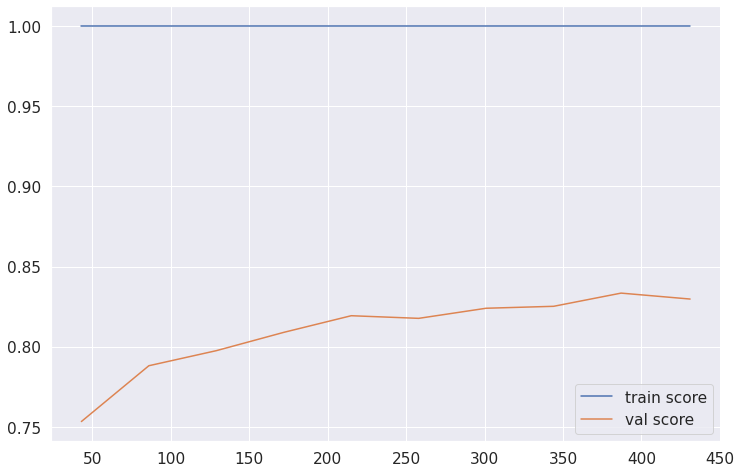

In [287]:
evaluation(simple_model2, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, cv=5, scoring='f1')

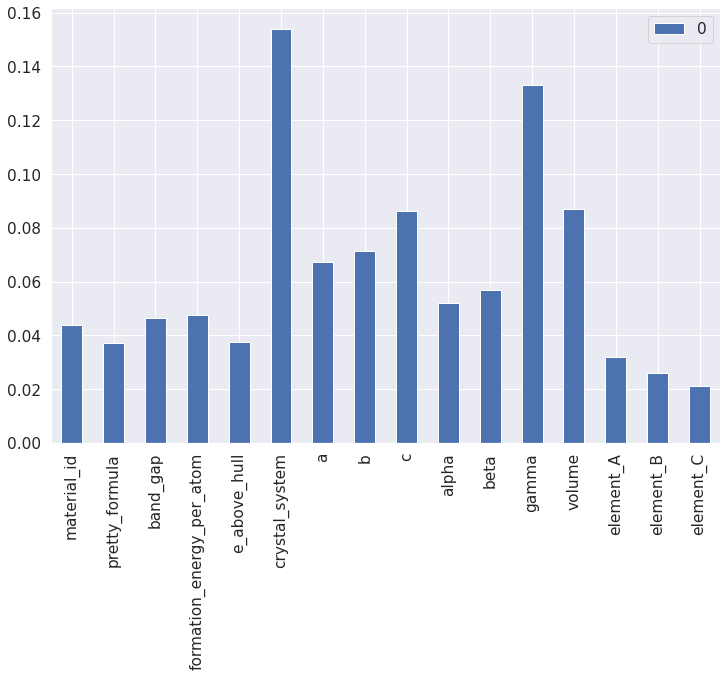

In [286]:
pd.DataFrame(simple_model2.feature_importances_, 
             index=X_train.columns).plot.bar(figsize=(12,8))

### **Feature selection**: the simple models are overfitting, so lets try to select the most important features

#### SelectKBest with ANOVA (f_classif)

In [288]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif #ANOVA!

In [296]:
model_feat_sel = make_pipeline(SelectKBest(f_classif, k=10), # I have 16 in total
                      RandomForestClassifier(random_state=11))

[[64  6]
 [ 7 58]]
              precision    recall  f1-score   support

           0       0.90      0.91      0.91        70
           1       0.91      0.89      0.90        65

    accuracy                           0.90       135
   macro avg       0.90      0.90      0.90       135
weighted avg       0.90      0.90      0.90       135



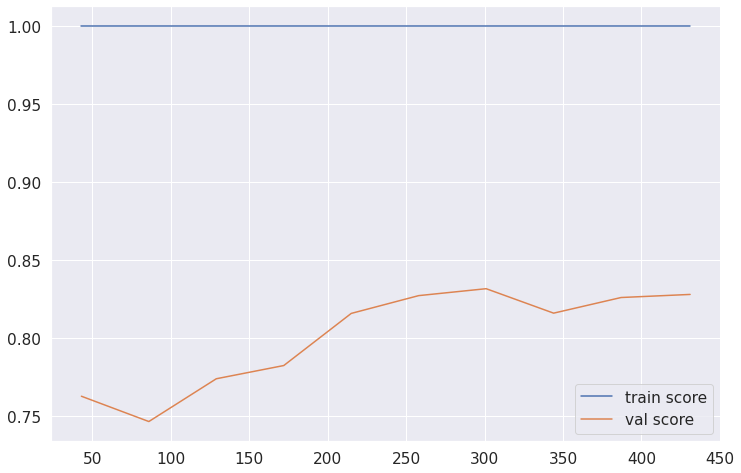

In [297]:
evaluation(model_feat_sel, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, cv=5, scoring='f1')

#### PolynomialFeatures

In [299]:
from sklearn.preprocessing import PolynomialFeatures

In [313]:
model_feat_sel2 = make_pipeline(PolynomialFeatures(2, include_bias=False), 
                      SelectKBest(f_classif, k=10),
                      RandomForestClassifier(random_state=11))

[[64  6]
 [11 54]]
              precision    recall  f1-score   support

           0       0.85      0.91      0.88        70
           1       0.90      0.83      0.86        65

    accuracy                           0.87       135
   macro avg       0.88      0.87      0.87       135
weighted avg       0.88      0.87      0.87       135



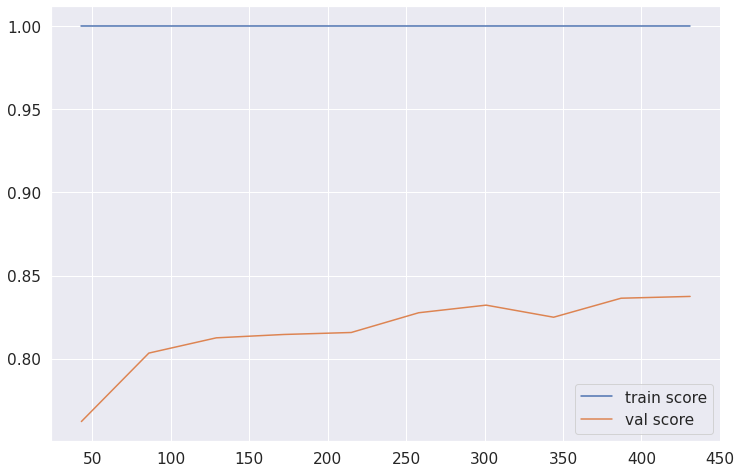

In [314]:
evaluation(model_feat_sel2, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, cv=5, scoring='f1')

**conclusion on feature importance**: SelectKBest alone is better than PolynomialFeatures, although we have an overfitting with both.

### Trying different models using **Pipeline**

In [463]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC 
# SVC - efficace pour les datasets de taille intermediare ou petit, needs
# normalization

from sklearn.preprocessing import StandardScaler

In [464]:
RandomForest = make_pipeline(SelectKBest(f_classif, k=10), 
                             RandomForestClassifier(random_state=11))

AdaBoost = make_pipeline(SelectKBest(f_classif, k=10), 
                         AdaBoostClassifier(random_state=11))

# SVM (support vector machine) needs normalization
SVM = make_pipeline(SelectKBest(f_classif, k=10),
                    StandardScaler(), 
                    SVC(probability=True, random_state=11))

KNN = make_pipeline(SelectKBest(f_classif, k=10), 
                    StandardScaler(), 
                    KNeighborsClassifier())

In [465]:
list_of_models = {'RandomForest' : RandomForest, 
                  'AdaBoost' : AdaBoost,
                  'SVM' : SVM,
                  'KNN' : KNN}

RandomForest
[[64  6]
 [ 7 58]]
              precision    recall  f1-score   support

           0       0.90      0.91      0.91        70
           1       0.91      0.89      0.90        65

    accuracy                           0.90       135
   macro avg       0.90      0.90      0.90       135
weighted avg       0.90      0.90      0.90       135

AdaBoost
[[63  7]
 [18 47]]
              precision    recall  f1-score   support

           0       0.78      0.90      0.83        70
           1       0.87      0.72      0.79        65

    accuracy                           0.81       135
   macro avg       0.82      0.81      0.81       135
weighted avg       0.82      0.81      0.81       135

SVM
[[64  6]
 [17 48]]
              precision    recall  f1-score   support

           0       0.79      0.91      0.85        70
           1       0.89      0.74      0.81        65

    accuracy                           0.83       135
   macro avg       0.84      0.83      0.83  

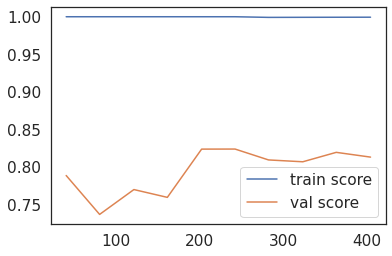

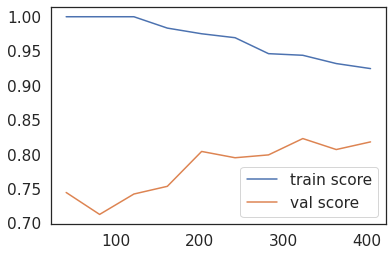

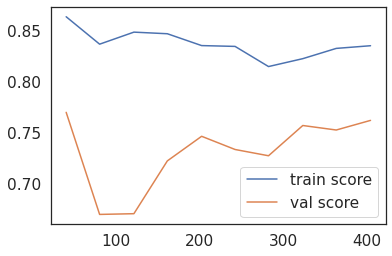

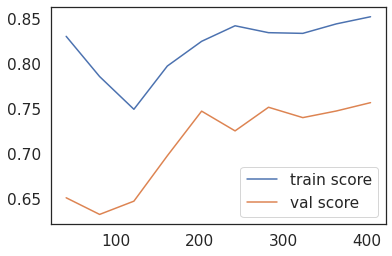

In [477]:
for name, model in list_of_models.items():
    print(name)
    evaluation(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, figsize=(6, 4))

### **Calibration Plot**

In [458]:
y_probs_ada = AdaBoost.predict_proba(X_test)
y_probs_KNN = KNN.predict_proba(X_test)
y_probs_SVM = SVM.predict_proba(X_test)
y_probs_RandomForest = RandomForest.predict_proba(X_test)

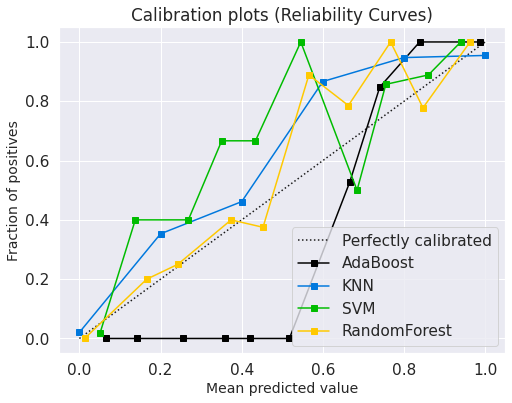

In [460]:
probas_list = [y_probs_ada, y_probs_KNN, y_probs_SVM, y_probs_RandomForest]

clf_names = ['AdaBoost', 'KNN', 'SVM', 'RandomForest']

skplt.metrics.plot_calibration_curve(y_test, 
                                     probas_list=probas_list, 
                                     clf_names = clf_names,
                                     title_fontsize="medium",
                                     text_fontsize="small",
                                     figsize=(8,6))

**conclusion on multiple models**: AdaBoost is the best as it has solved the overfitting and both train and validation curves get closer together, with the validation values increasing

### Optimizing even further: GridSearchCV with AdaBoost

In [320]:
from sklearn.model_selection import GridSearchCV

In [321]:
AdaBoost # as pipeline

Pipeline(steps=[('selectkbest', SelectKBest()),
                ('adaboostclassifier', AdaBoostClassifier(random_state=11))])

In [327]:
AdaBoost.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'selectkbest', 'adaboostclassifier', 'selectkbest__k', 'selectkbest__score_func', 'adaboostclassifier__algorithm', 'adaboostclassifier__base_estimator', 'adaboostclassifier__learning_rate', 'adaboostclassifier__n_estimators', 'adaboostclassifier__random_state'])

In [324]:
import inspect
inspect.signature(AdaBoostClassifier.__init__) # hyperparams

<Signature (self, base_estimator=None, *, n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=None)>

In [328]:
hyper_params = {'adaboostclassifier__n_estimators' : [10, 50, 100, 500],
                'adaboostclassifier__learning_rate' : [0.0001, 0.001, 0.01, 0.1, 1.0]}

In [329]:
grid = GridSearchCV(AdaBoost, hyper_params, scoring='f1', cv=4)

grid.fit(X_train, y_train)

print(grid.best_params_)

print(grid.best_score_)

y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred)) #l'ordre est important - test avant

{'adaboostclassifier__learning_rate': 0.1, 'adaboostclassifier__n_estimators': 50}
0.8297721822541966
              precision    recall  f1-score   support

           0       0.91      0.87      0.89        70
           1       0.87      0.91      0.89        65

    accuracy                           0.89       135
   macro avg       0.89      0.89      0.89       135
weighted avg       0.89      0.89      0.89       135



[[61  9]
 [ 6 59]]
              precision    recall  f1-score   support

           0       0.91      0.87      0.89        70
           1       0.87      0.91      0.89        65

    accuracy                           0.89       135
   macro avg       0.89      0.89      0.89       135
weighted avg       0.89      0.89      0.89       135



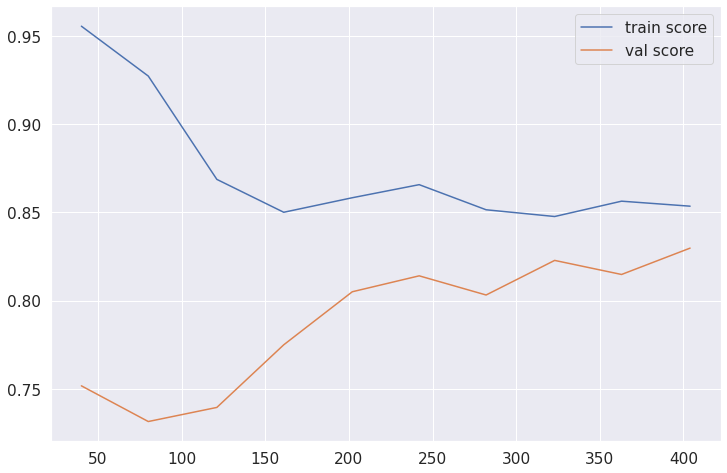

In [331]:
evaluation(grid.best_estimator_, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, cv=4, scoring='f1')
# no more overfitting!

### Amplifying the optimization with GridSearchCV and AdaBoost

In [332]:
AdaBoost # as pipeline
AdaBoost.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'selectkbest', 'adaboostclassifier', 'selectkbest__k', 'selectkbest__score_func', 'adaboostclassifier__algorithm', 'adaboostclassifier__base_estimator', 'adaboostclassifier__learning_rate', 'adaboostclassifier__n_estimators', 'adaboostclassifier__random_state'])

In [335]:
hyper_params = {'adaboostclassifier__n_estimators' : [10, 50, 100, 200, 300, 400, 500],
                'adaboostclassifier__learning_rate' : [0.0001, 0.001, 0.01, 0.5, 0.1, 1.0],
                'selectkbest__k' : range(1, 16)}

{'adaboostclassifier__learning_rate': 0.1, 'adaboostclassifier__n_estimators': 50, 'selectkbest__k': 5}
0.8372766802155213
              precision    recall  f1-score   support

           0       0.95      0.83      0.89        70
           1       0.84      0.95      0.89        65

    accuracy                           0.89       135
   macro avg       0.89      0.89      0.89       135
weighted avg       0.90      0.89      0.89       135

[[58 12]
 [ 3 62]]
              precision    recall  f1-score   support

           0       0.95      0.83      0.89        70
           1       0.84      0.95      0.89        65

    accuracy                           0.89       135
   macro avg       0.89      0.89      0.89       135
weighted avg       0.90      0.89      0.89       135



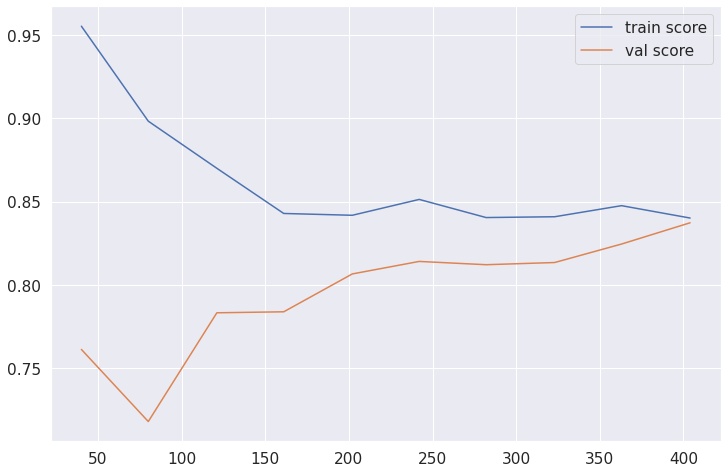

In [336]:
grid_ada = GridSearchCV(AdaBoost, hyper_params, scoring='f1', cv=4)

grid_ada.fit(X_train, y_train)

print(grid_ada.best_params_)

print(grid_ada.best_score_)

y_pred = grid_ada.predict(X_test)

print(classification_report(y_test, y_pred)) #l'ordre est important - test avant

evaluation(grid_ada.best_estimator_, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, cv=4, scoring='f1')
# no more overfitting!

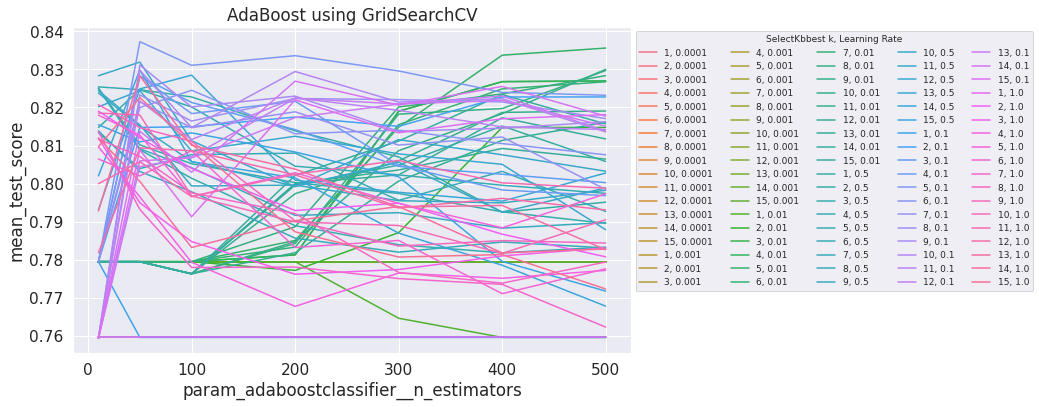

In [342]:
# Lets plot the results of the GridSearchCV using seaborn's lineplot
# Lets first transform the cv_results from GridSearchCV into DataFrame to better manipulation
cv_results = pd.DataFrame(grid_ada.cv_results_)

# Lets try to improve the graph using a pdSeries for the hue parameter
hue = cv_results[["param_selectkbest__k", 'param_adaboostclassifier__learning_rate']].apply(
    lambda row: f"{row.param_selectkbest__k}, {row.param_adaboostclassifier__learning_rate}", axis=1)

plt.subplots(figsize=(10, 6))

# Plotting the final data
sns.lineplot(data=cv_results, x="param_adaboostclassifier__n_estimators", y="mean_test_score", 
             hue=hue).set(title='AdaBoost using GridSearchCV')

plt.legend(bbox_to_anchor=(1, 1), title='SelectKbbest k, Learning Rate', title_fontsize=9, fontsize=9, ncol=5)


**conclusion of optimization of AdaBoost hyperparams with GridSearchCV**: 
- no more overfitting
- metrics are
      precision   recall   f1-score   support

           0       0.95      0.83      0.89        
           1       0.84      0.95      0.89 

- difference between train score and validation score gets smaller -> good!

### Saving the model

In [343]:
from joblib import dump, load # saving and loading model

import datetime # track each exp with date and time

In [346]:
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join('drive/MyDrive/ML_Perovskites/models',
                          datetime.datetime.now().strftime('%Y%m%d-%H%M%s'))
  model_path = modeldir + "-" + suffix + ".h5" # save the format of model
  print(f"Saving model to: {model_path}...")
  dump(model, model_path)
  return model_path

In [347]:
def load_model(model_path):
  """
  Loads a saved model from a specific path.
  """
  print(f"Loading saved model from: {model_path}...")
  model = load(model_path)
  return model

In [349]:
# Saving the GridSearchCV model
# save_model(grid_ada.best_estimator_, suffix='grid_ada')

Saving model to: drive/MyDrive/ML_Perovskites/models/20230207-15431675784582-grid_ada.h5...


'drive/MyDrive/ML_Perovskites/models/20230207-15431675784582-grid_ada.h5'

In [350]:
# loading back the GridSearchCV model
model_best_CV_loaded = load_model("drive/MyDrive/ML_Perovskites/models/20230207-15431675784582-grid_ada.h5")

Loading saved model from: drive/MyDrive/ML_Perovskites/models/20230207-15431675784582-grid_ada.h5...


[[58 12]
 [ 3 62]]
              precision    recall  f1-score   support

           0       0.95      0.83      0.89        70
           1       0.84      0.95      0.89        65

    accuracy                           0.89       135
   macro avg       0.89      0.89      0.89       135
weighted avg       0.90      0.89      0.89       135



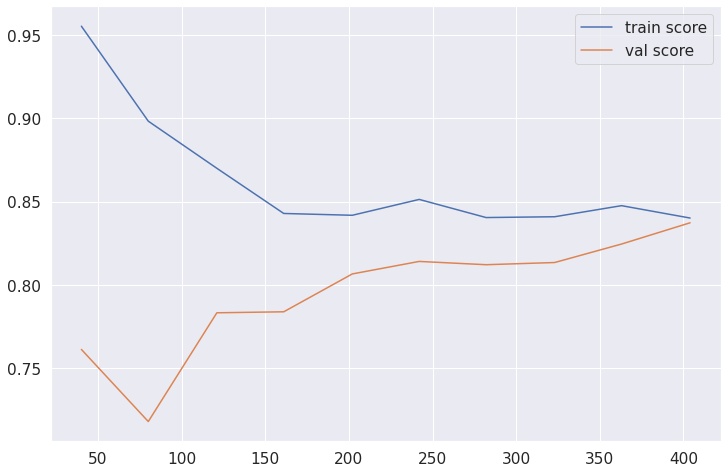

In [351]:
# checking if the loaded model is the same
evaluation(model_best_CV_loaded, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, cv=4, scoring='f1')

In [424]:
y_preds = model_best_CV_loaded.predict(X_test)

### Precision vs Recall curve

In [357]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score

In [354]:
precision, recall, threshold = precision_recall_curve(y_test, 
                       model_best_CV_loaded.decision_function(X_test))

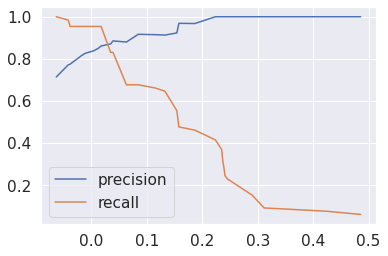

In [356]:
plt.plot(threshold, precision[:-1], label = 'precision')
plt.plot(threshold, recall[:-1], label = 'recall')
plt.legend()

In [358]:
## lets create a function to take into account the decision_function
def model_final(model, X, threshold=0):
    return model.decision_function(X) > threshold

In [389]:
for threshold in np.arange(-0.1, 0.1, 0.01):
  y_pred = model_final(model_best_CV_loaded, X_test, threshold=threshold)
  
  f1 = f1_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)

  print(threshold, f1, recall)

-0.1 0.8333333333333333 1.0
-0.09000000000000001 0.8333333333333333 1.0
-0.08000000000000002 0.8333333333333333 1.0
-0.07000000000000002 0.8333333333333333 1.0
-0.060000000000000026 0.8648648648648649 0.9846153846153847
-0.05000000000000003 0.8648648648648649 0.9846153846153847
-0.040000000000000036 0.8551724137931034 0.9538461538461539
-0.03000000000000004 0.8794326241134751 0.9538461538461539
-0.020000000000000046 0.8794326241134751 0.9538461538461539
-0.01000000000000005 0.8920863309352518 0.9538461538461539
-5.551115123125783e-17 0.8920863309352518 0.9538461538461539
0.00999999999999994 0.8985507246376813 0.9538461538461539
0.019999999999999934 0.8503937007874016 0.8307692307692308
0.029999999999999943 0.8503937007874016 0.8307692307692308
0.039999999999999925 0.7652173913043478 0.676923076923077
0.049999999999999906 0.7652173913043478 0.676923076923077
0.059999999999999915 0.7652173913043478 0.676923076923077
0.06999999999999992 0.7787610619469026 0.676923076923077
0.0799999999999

### Visualization using **Confusion Matrix**

In [421]:
import scikitplot as skplt

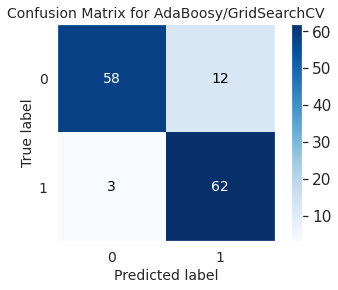

In [445]:
skplt.metrics.plot_confusion_matrix(y_test, 
                                    y_preds, 
                                    normalize=False, 
                                    title = 'Confusion Matrix for AdaBoosy/GridSearchCV',
                                    title_fontsize="small",
                                    text_fontsize="small"
                                    )

### Receiver Operating Characteristic (**ROC**) Curve

In [433]:
# Make predictions with probabilities
y_probs = model_best_CV_loaded.predict_proba(X_test)

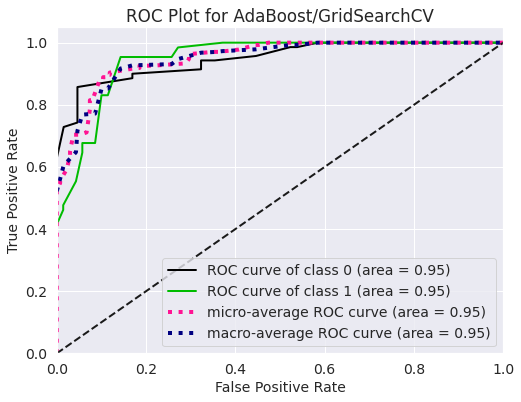

In [440]:
skplt.metrics.plot_roc(y_test, 
                       y_probs, 
                       title = 'ROC Plot for AdaBoost/GridSearchCV',
                       title_fontsize="medium",
                       text_fontsize="small",
                       figsize=(8,6)
                        )

### Visualizing the final predictions

In [406]:
# Making a copy of the X_test
dados2 = X_test.copy()

# Adding the true and pred labels
dados2["true_labels"] = y_test
dados2["pred_labels"] = y_preds

In [407]:
# Transforming back to categorical pandas
dados2['material_reversed'] = pd.Series(dados2['pretty_formula'].map(cat_pretty_formula))
type(dados2)

pandas.core.frame.DataFrame

In [408]:
dados2.head()

,material_id,pretty_formula,band_gap,formation_energy_per_atom,e_above_hull,crystal_system,a,b,c,alpha,beta,gamma,volume,element_A,element_B,element_C,true_labels,pred_labels,material_reversed
89,596,198,0.0,-0.839507,0.158116,1,4.070076,4.070076,4.070076,90.00000,90.000000,90.000000,67.422920,32,50,1,0,0,KPuO3
376,263,422,1.5,-2.120515,0.019890,5,5.419377,5.419377,6.266180,64.38122,64.381366,89.998445,145.621359,45,49,31,1,0,VZnO3
237,212,19,0.0,-1.982327,0.156518,2,5.648616,5.648616,10.488773,90.00000,90.000000,120.000000,289.827390,3,19,1,1,1,AlFeO3
550,126,255,0.0,-1.763893,0.684223,1,3.963751,3.963751,3.963751,90.00000,90.000000,90.000000,62.275768,35,45,6,0,0,LuScO3
435,91,50,0.0,-1.536702,0.710592,1,3.556543,3.556543,3.556543,90.00000,90.000000,90.000000,44.986706,7,31,1,0,0,CaBO3


In [409]:
# for fixing ticks
import matplotlib.ticker

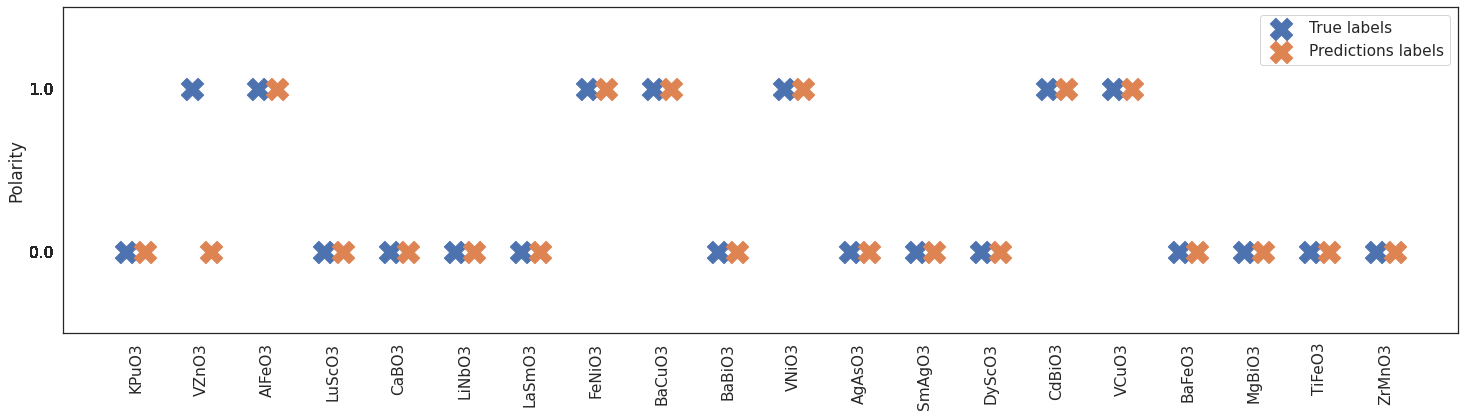

In [501]:
fig, ax = plt.subplots(figsize=(25, 6))

X_axis = np.linspace(1, 400, len(dados2['material_reversed'][0:20]))

plt.scatter(X_axis - 3, dados2['true_labels'][0:20], label="True labels", marker="X", s=500)
plt.scatter(X_axis + 3, dados2['pred_labels'][0:20], label="Predictions labels", marker="X", s=500)

plt.ylabel("Polarity")
plt.legend()

plt.ylim(-0.5, 1.5)
plt.yticks(y, [0, 1])

formatter = matplotlib.ticker.StrMethodFormatter("{x:.1f}")
plt.gca().yaxis.set_major_formatter(formatter)

_ = plt.xticks(X_axis, dados2['material_reversed'][0:20], rotation=90)

### **Conclusions**:
- Boosting, the support vector machine and KNNeighbors models perfom the best (AdaBoost, SVM, KNN) without overfitting and $F1 > 0.83$ and $recall > 0.90$
- AdaBoost is the one that gets the train score and the validation score the closest to each other, and thats why we chose it to optimize
- The most important features for classifying the polarity are the `crystal_system` and the lattime params (which is in accordance with the physical meaning of the system)
- Using GridSearchCV we optimized the AdaBoost classifier reaching very high metrics of about 0.9 for both recall and F1
-**biggest conclusion**: it is possible to know if a perovskite material is polar or not only giving the a few features, not needing neither the space group or point group, or symmetry operations (rotation, translation...)


- still to improve:
  - more data! 
  - try an Ensemble model
  - check what happens if we remove the crystal structure feature (it will be harder for the model to classify?)
  - extent analysis to other class of compounds
  - encode the object features ina different way (one hot encoding ...)
